# Data Management Project: Bitcoin sentiment analysis

## Data sources:
- YFinance library
- NyTimes news: API endpoint -> https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey

(Limit NYtimes: Yes, there are two rate limits per API: 500 requests per day and 5 requests per minute. You should sleep 12 seconds between calls to avoid hitting the per minute rate limit. If you need a higher rate limit, please contact us at code@nytimes.com.)

Important: 
- create in your environment a .env file
- write: NY_KEY = "your_key"
- use the command load_dotenv()
- key = os.getenv("NY_KEY")

In [ ]:
!pip install -r requirements.txt

In [21]:
# utility libraries
import os
import json
import time
import random
import warnings
from tqdm import tqdm
from bson.json_util import dumps
from bson.json_util import loads

# data preprocessing libraries
import numpy as np
import pandas as pd

# time series utility libraries
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

# api utility library
import requests

# key management library
from dotenv import load_dotenv

# plot library
import matplotlib.pyplot as plt

# kafka libraries
from kafka import KafkaProducer
from kafka import KafkaConsumer

# Mongodb library
from pymongo import MongoClient, UpdateOne

# YFinance library
import yfinance as yf

load_dotenv()

# --- 4. VISUALIZATION ---
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# --- 5. MACHINE LEARNING & TEXT ANALYSIS (Scikit-Learn) ---
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity

# --- 6. ADVANCED NLP (Transformers & PyTorch) ---
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

# --- 7. NATURAL LANGUAGE PROCESSING (NLTK) ---
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


# --- 8. INITIAL SETUP & CONFIGURATION ---
# A. Load Environment Variables
load_dotenv()


# B. Suppress Warnings (Optional, keeps output clean)
warnings.filterwarnings('ignore') 

# C. NLTK Downloads (Run once to ensure dictionaries are present)
print("🔧 Checking NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)

print(f"All libraries imported successfully.")

🔧 Checking NLTK resources...
All libraries imported successfully.


## Prices:

We want to store prices from 2018-01-01 to 2025-12-12 for Bitcoin and Ethereum, two important cryptovalues.

In [25]:
df = yf.download(["BTC-USD","ETH-USD"], start="2018-01-01", end="2025-12-12")
df.head()

[*********************100%***********************]  2 of 2 completed


Price              Close                      High                        Low  \
Ticker           BTC-USD     ETH-USD       BTC-USD      ETH-USD       BTC-USD   
Date                                                                            
2018-01-01  13657.200195  772.640991  14112.200195   782.530029  13154.700195   
2018-01-02  14982.099609  884.443970  15444.599609   914.830017  13163.599609   
2018-01-03  15201.000000  962.719971  15572.799805   974.471008  14844.500000   
2018-01-04  15599.200195  980.921997  15739.700195  1045.079956  14522.200195   
2018-01-05  17429.500000  997.719971  17705.199219  1075.390015  15202.799805   

Price                           Open                   Volume              
Ticker         ETH-USD       BTC-USD     ETH-USD      BTC-USD     ETH-USD  
Date                                                                       
2018-01-01  742.004028  14112.200195  755.757019  10291200000  2595760128  
2018-01-02  772.346008  13625.000000  772.346008  16846600192  5783349760  
2018-01-03  868.450989  14978.200195  886.000000  16871900160  5093159936  
2018-01-04  946.085999  15270.700195  961.713013  21783199744  6502859776  
2018-01-05  956.325012  15477.200195  975.750000  23840899072  6683149824

In [5]:
df.isna().sum() # There is no Missing Values

Price   Ticker 
Close   BTC-USD    0
        ETH-USD    0
High    BTC-USD    0
        ETH-USD    0
Low     BTC-USD    0
        ETH-USD    0
Open    BTC-USD    0
        ETH-USD    0
Volume  BTC-USD    0
        ETH-USD    0
dtype: int64

In [6]:
df_stacked = df.stack(level=1, future_stack=True)
# reset index 
df_final = df_stacked.reset_index()


# ('Date' -> 'date', 'Ticker' -> 'ticker', 'Adj Close' -> 'adj_close')
df_final.columns = [c.lower().replace(' ', '_') for c in df_final.columns]

# date to native date-format
df_final['date'] = pd.to_datetime(df_final['date'])

# --- 3. EXTRA Cleaning ---
# NaN --> None (beacause of the MongoDB logic)
df_final = df_final.where(pd.notnull(df_final), None)

# Dataframe to List of Dict
records = df_final.to_dict(orient='records')

print(f"Ready to insert {len(records)} record.")

# --- 4. MONGODB INSERT ---
client = MongoClient("mongodb://localhost:27017")
db = client['DM_DB']
collection = db['Crypto']

try:
    if records:
        
        result = collection.insert_many(records)
        print(f"{len(result.inserted_ids)} document in 'CryptoPrices'.")
    else:
        print("Nothing to insert.")

except Exception as e:
    print(f"Error during the insertion: {e}")

# --- Control ---
print("\nVerifying the last btc")
latest = collection.find_one({"ticker": "BTC-USD"}, sort=[("date", -1)])
print(latest)

Ready to insert 5804 record.
5804 document in 'CryptoPrices'.

Verifying the last btc
{'_id': ObjectId('6945798fd65f26c5a42ef2d5'), 'date': datetime.datetime(2025, 12, 11, 0, 0), 'ticker': 'BTC-USD', 'close': 92511.3359375, 'high': 93554.265625, 'low': 89335.296875, 'open': 92011.3046875, 'volume': 64532834621}


### Some Visualization

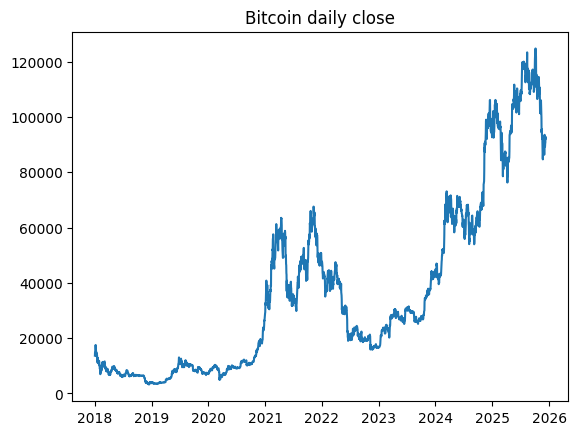

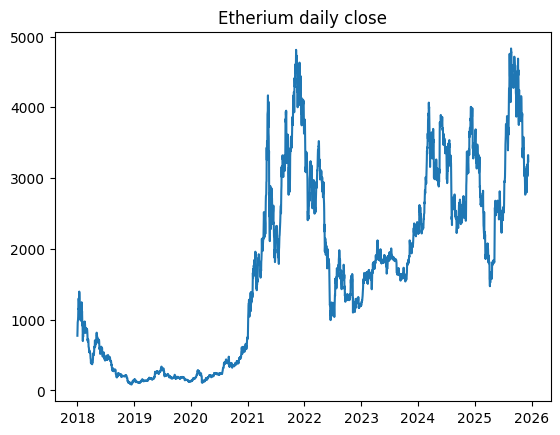

In [14]:
plt.figure()
plt.plot(df.index,df['Close']['BTC-USD'])
plt.title("Bitcoin daily close")
plt.show()
plt.figure()
plt.plot(df.index,df['Close']['ETH-USD'])
plt.title("Etherium daily close")
plt.show()

## NyTimes article:

1. **Data retrieval from the New York Times API**  
   - Uses the API key stored in the environment variable `NY_KEY`.  
   - Searches for the queries `"Bitcoin"` and `"Crypto"`.  
   - Iterates through 100 pages of results for each query.

2. **Request and error handling**  
   - Each HTTP request is executed using `requests.get`.  
   - The response status is checked with `raise_for_status()` to catch any HTTP errors.  
   - In case of an error (e.g., `429 Too Many Requests`, timeout, connection issues), the error is logged and the loop continues with the next request.

3. **Sending data to Kafka**  
   - If the response is valid, the JSON data is sent to a Kafka topic corresponding to the query (`Bitcoin` or `Crypto`).  
   - This allows real-time processing or storage of the data via a Kafka consumer.

4. **Rate limit management**  
   - After each request, the script waits 15 seconds (`time.sleep(15)`) to avoid exceeding NYT API limits, reducing the risk of `429 Too Many Requests` errors.

**Note:** The script is designed to safely scrape data while respecting the NYT API's per-minute and daily limits, sending the collected data to Kafka for further processing.


We want to use a `Kafka producer and consumer` to store NyTimes Articles into the DB, thus because of the risk to lost data during the api request procedure.

In [ ]:
# ---------------------------------------------------------
# User Configuration
# ---------------------------------------------------------


start_date = date(2018, 1, 1) # Set Start and End Date
end_date = date(2025, 12, 12)

# ---------------------------------------------------------
# ---------------------------------------------------------

# Setup Kafka
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

DAILY_LIMIT = 480 # We choose a daily-limit request of 480 istead of 500 (the actual NyTimes limit) to have some debug-call.
calls_made = 0 # counter

key = os.getenv("NY_KEY") # get the api key
queries = ["Bitcoin", "Crypto", "Ethereum"] # Choosen queries
current_date = start_date

print(f"Script Start from: {start_date}")

while current_date < end_date:
    next_month = current_date + relativedelta(months=1)
    
    begin_str = current_date.strftime("%Y%m%d")
    end_str = next_month.strftime("%Y%m%d")
    
    print(f"Month: {begin_str} - {end_str} ---")
    
    for q in queries:
        print(f"{q}...")
        
        # Cycle for every page ffrom 0 to 100
        for page in range(100): 
            
            # --- Daily-limit control ---
            if calls_made >= DAILY_LIMIT:
                print(f"STOP: daily requests limit reached ({calls_made}).")
                print(f"Restart from: {begin_str}, Query: {q}, Page: {page}")
                exit() # Close the Program

            # ------
            attempt_success = False
            should_stop_pages = False

            while not attempt_success:
                try:
                    # endpoint
                    url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?q={q}&begin_date={begin_str}&end_date={end_str}&page={page}&api-key={key}"
                    
                    response = requests.get(url)
                    
                    # CASe 1: ERROR 429 (too much requests, one each 12 second)
                    if response.status_code == 429:
                        print(f"Error (429). waiting for 70 second e re-try the page: {page}...")
                        time.sleep(70) 
                        continue 
                    
                    # Control for other error
                    response.raise_for_status()

                    data = response.json()
                    articles = data.get('response', {}).get('docs', [])

                    # CASE 2: Empty Articles --> go tu the next query
                    if not articles:
                        print(f"No article found at page {page}.")
                        attempt_success = True 
                        should_stop_pages = True
                        break 

                    # CASE 3: Everything OK -> SEND TO KAFKA
                    for article in articles:
                        clean_doc = {
                            'remote_id': article.get('_id'),
                            'web_url': article.get('web_url'),
                            'pub_date': article.get('pub_date'),
                            'abstract': article.get('abstract'),
                            'lead_paragraph': article.get('lead_paragraph'),
                            'title': article.get('headline', {}).get('main'),
                            'word_count': article.get('word_count'),
                            'source_query': q
                        }
                        producer.send(q, clean_doc)
            
                    producer.flush()
                    print(f"Found {len(articles)} articles (Page {page})")
                    
                    calls_made += 1
                    attempt_success = True 
                    
                    
                    time.sleep(12) 

                except Exception as e:
                    # CASE 4: Generic Error
                    print(f"Generic Error: {e}")
                    print("Try after 15 seconds")
                    time.sleep(15)
                    

            if should_stop_pages:
                break 

    current_date = next_month

1. **Kafka Consumers Setup**  
   - Two separate consumers are created:
     - `consumer_bitcoin` subscribes to the `"Bitcoin"` topic.
     - `consumer_crypto` subscribes to the `"Crypto"` topic.
   - Both consumers:
     - Connect to the Kafka broker at `localhost:9092`.
     - Deserialize messages from JSON using `json.loads`.
     - Start reading from the earliest available message (`auto_offset_reset="earliest"`) to process past messages.
     - Use a new consumer group `"debug-group"` to avoid committing offsets from previous runs.

2. **MongoDB Setup**  
   - Connects to a local MongoDB instance (`mongodb://localhost:27017`).
   - Uses the database `bitcoin_pr`.
   - Stores articles in the collection `Article`.

3. **Message Consumption and Storage**  
   - For each message received from the `"Bitcoin"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Bitcoin"`.
     - Inserts the document into the MongoDB collection.
   - For each message received from the `"Crypto"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Crypto"`.
     - Inserts the document into MongoDB.

4. **Notes**
   - Using `auto_offset_reset="earliest"` allows the consumer to read **all previous messages** in the topic, which is useful for debugging or reprocessing data.
   - Each consumer runs in a blocking loop, continuously waiting for new messages.
   - Ensure MongoDB is running locally before executing the script.



In [ ]:
consumer_bitcoin = KafkaConsumer(
    "Bitcoin",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",  
    enable_auto_commit=True,
    group_id="debug-group",         
    consumer_timeout_ms=10000
)

consumer_crypto = KafkaConsumer(
    "Crypto",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   
    enable_auto_commit=True,
    group_id="debug-group-crypto",        
    consumer_timeout_ms=10000
)

consumer_eth = KafkaConsumer(
    "Ethereum",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   
    enable_auto_commit=True,
    group_id="debug-group-eth",         
    consumer_timeout_ms=10000
)



In [ ]:
client = MongoClient("mongodb://localhost:27017")

db = client['DM_DB']

collection = db['Article']

print("Waiting for Ethereum messages...")
for msg in consumer_eth:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Ethereum'
    collection.insert_one(doc)

print("Waiting for Bitcoin messages...")
for msg in consumer_bitcoin:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Bitcoin'
    collection.insert_one(doc)

print("Waiting for Crypto messages...")
for msg in consumer_crypto:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Crypto'
    collection.insert_one(doc)

print("All messages consumed.")


In [ ]:
client = MongoClient("mongodb://localhost:27017")

db = client['DM_DB']

collection = db['Articles']


#### This cells are useful to load the json data downloaded from the api calls

In [ ]:
#SAVE The Data in a Json file
output_filename = 'completo.json'

print(f"Start Import of {output_filename} ---")

cursor = collection.find({}) 

articles_list = list(cursor)

if len(articles_list) > 0:
    
    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
        
            f.write(dumps(articles_list, indent=4, ensure_ascii=False))
            
        print(f"Saved {len(articles_list)} articles in '{output_filename}'.")
        print(f"Path: {os.path.abspath(output_filename)}")
        
    except Exception as e:
        print(f"Error: {e}")
else:
    print("Empty Articles")



--- Inizio esportazione su file JSON: completo.json ---
✅ Successo! Salvati 2902 articoli nel file 'completo.json'.
   Percorso file: c:\Users\tomma\Desktop\magistrale\DataMan-Project\completo.json
Fine procedura.


In [46]:

input_filename = 'articoli_nyt_completofin.json' # Change with the name of the file
db_name = 'DM_DB' # Choose a DB name
collection_name = 'Article'

# Connect to DB
client = MongoClient("mongodb://localhost:27017")
db = client[db_name]
collection = db[collection_name]

print(f"Start Import {input_filename} to MongoDB ({collection_name}) ---")

# 1. Does the file exist?
if not os.path.exists(input_filename):
    print(f"Error: file '{input_filename}' doesn't exist.")
    exit()

try:
    # 2. Json 
    with open(input_filename, 'r', encoding='utf-8') as f:
        
        data = loads(f.read())

    if isinstance(data, list) and len(data) > 0:
       
        # 3. Insert into MongoDB (Bulk Insert)
        result = collection.insert_many(data, ordered=False)
        print(f"Complete insertion, {len(result.inserted_ids)} documents.")
        

    else:
        print("empty json")

except Exception as e:
    print(f"Error: {e}")


Start Import articoli_nyt_completofin.json to MongoDB (Article) ---
Complete insertion, 914 documents.


### Duplicate

In [47]:
pipeline = [

    {

        "$group": {

            "_id": "$remote_id",  

            "count": {"$sum": 1},

            "docs": {"$push": "$_id"}

        }

    },

    {

        "$match": {

            "count": {"$gt": 1}

        }

    }

]



duplicati = list(collection.aggregate(pipeline))



print(f"Found {len(duplicati)} duplicated.")



for d in duplicati[:5]:

    print(f"Same URL {d['_id']} in {d['count']} Articles.")



Found 2010 duplicated.
Same URL nyt://article/ab63c707-2349-5452-927a-27fb129d531a in 2 Articles.
Same URL nyt://article/5e335356-9bad-50bf-90c2-3b30eb68e3e5 in 2 Articles.
Same URL nyt://article/b71656fe-d474-555d-9f03-2685f41b055e in 2 Articles.
Same URL nyt://article/83d96d44-831d-5070-8a9f-d36c872bde24 in 2 Articles.
Same URL nyt://article/621f84d7-5e6c-5a34-a61c-43fbb2d046b4 in 2 Articles.


In [48]:
num_articles = collection.count_documents({})
print(f"Number of articles in the collection: {num_articles}")

num_bitcoin = collection.count_documents({'source_query': 'Bitcoin'})
num_crypto = collection.count_documents({'source_query': 'Crypto'})
num_eth = collection.count_documents({'source_query': 'Ethereum'})


print(f"Number of Bitcoin articles: {num_bitcoin}")
print(f"Number of Crypto articles: {num_crypto}")
print(f"Number of Ethereum articles: {num_eth}")




Number of articles in the collection: 7257
Number of Bitcoin articles: 2458
Number of Crypto articles: 4172
Number of Ethereum articles: 627


In [50]:
#Duplication Rate:
len(duplicati)/num_articles*100

27.69739561802398

Deduplication:

In [ ]:
# DEDUPLICATION:



duplicati = list(collection.aggregate(pipeline))

print(f"Found {len(duplicati)} duplicated URL.")

ids_da_cancellare = []

for d in duplicati:
    ids_da_cancellare.extend(d['docs'][1:])

if ids_da_cancellare:
    print(f"Deleting {len(ids_da_cancellare)} duplicated Articles...")

    risultato = collection.delete_many({"_id": {"$in": ids_da_cancellare}})

else:
    print("No Duplicated Articles.")



Found 2010 duplicated URL.
Deleting 3592 duplicated Articles...


In [ ]:
pipeline = [
    {
        "$group": {
            "_id": "$remote_id",  
            "count": {"$sum": 1},
            "docs": {"$push": "$_id"}
        }
    },
    {
        "$match": {
            "count": {"$gt": 1}
        }
    }
]



duplicati = list(collection.aggregate(pipeline))



print(f"Found {len(duplicati)} duplicated.")



for d in duplicati[:5]:

    print(f"Same URL {d['_id']} in {d['count']} Articles.")



Found 0 duplicated.


In [52]:
num_articles = collection.count_documents({})
print(f"Number of articles in the collection: {num_articles}")

num_bitcoin = collection.count_documents({'source_query': 'Bitcoin'})
num_crypto = collection.count_documents({'source_query': 'Crypto'})
num_eth = collection.count_documents({'source_query': 'Ethereum'})


print(f"Number of Bitcoin articles: {num_bitcoin}")
print(f"Number of Crypto articles: {num_crypto}")
print(f"Number of Ethereum articles: {num_eth}")




Number of articles in the collection: 3665
Number of Bitcoin articles: 1259
Number of Crypto articles: 2280
Number of Ethereum articles: 126


# Integration:


## For Each Day with context (Latest Version):

In [54]:
# 1. SETUP
client = MongoClient("mongodb://localhost:27017/")
db_source = client["DM_DB"]
db_dest = client["DM_DB_Integrated"] # DB Destination

print("Loading data...")
articles_data = list(db_source["Article"].find({}))
prices_data = list(db_source["Crypto"].find({}))

df_articles = pd.DataFrame(articles_data)
df_prices = pd.DataFrame(prices_data)

# --- Phase 1: Prices Preparation ---
rename_map = {
    'Ticker': 'asset', 'ticker': 'asset', 'Symbol': 'asset',
    'Date': 'date', 'Close': 'close', 'Open': 'open'
}
df_prices.rename(columns=rename_map, inplace=True)

# Normalizing Date ---> Jet lag
df_prices['date'] = pd.to_datetime(df_prices['date'], utc=True).dt.normalize()
df_prices = df_prices.sort_values(by=['asset', 'date'])
df_prices = df_prices.drop_duplicates(subset=['asset', 'date'], keep='last')

# List of Asset
all_assets = ['BTC-USD', 'ETH-USD']
print(f"Asset: {all_assets}")

price_map = {}
for record in df_prices.to_dict('records'):
    key = (record['asset'], record['date'])
    price_map[key] = {'open': record.get('open'), 'close': record.get('close')}

# --- Phase 2: Articles Preparation (Group by) ---
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'], utc=True).dt.normalize()

print("Group by day...")
articles_by_day = {}

for record in df_articles.to_dict('records'):
    d_date = record['pub_date']
    
    article_clean = {
        "remote_id": record.get('remote_id'),
        "title": record.get('title') if record.get('title') else record.get('headline', {}).get('main'),
        "url": record.get('web_url'),
        "source_query": record.get('source_query'),
        "abstract": record.get('abstract')
    }
    
    if d_date not in articles_by_day:
        articles_by_day[d_date] = []
    articles_by_day[d_date].append(article_clean)

# --- Phase 3: Daily Articles---

unique_dates = sorted(df_prices['date'].unique())

final_docs = []
print(f"Creazione documenti per {len(unique_dates)} giorni...")

for current_date in unique_dates:
    
    # 1. Daily articles acquisition
    daily_articles = articles_by_day.get(current_date, [])
    
    # 2. document structure
    doc = {
        "date": current_date,
        "date_str": current_date.strftime('%Y-%m-%d'), 
        "articles": daily_articles, 
        "article_count": len(daily_articles),
        "prices": {} 
    }
    
    # 3. Asset Metrics
    has_price_data = False 
    
    for asset in all_assets:
        
        def get_p(delta_days):
            target = current_date + timedelta(days=delta_days)
            return price_map.get((asset, target))

        t0 = get_p(0)       # Today
        t_m1 = get_p(-1)    # Yesterday
        t_p1 = get_p(1)     # Tomorrow
        t_m7 = get_p(-7)    # Last Week
        t_p7 = get_p(7)     # Next Week
        
        if not t0:
            continue
            
        has_price_data = True
        
        open_t0 = t0['open']
        close_t0 = t0['close']
        
        asset_data = {
            "open": open_t0,
            "close": close_t0,
            "intraday_change": close_t0 - open_t0 if open_t0 else None,
            "context": {
                "close_prev_day": t_m1['close'] if t_m1 else None,
                "close_next_day": t_p1['close'] if t_p1 else None,
                "close_prev_week": t_m7['close'] if t_m7 else None,
                "close_next_week": t_p7['close'] if t_p7 else None
            },
            "future_trend": {
                "next_day_diff": t_p1['close'] - close_t0 if t_p1 else None,
                "next_week_diff": t_p7['close'] - close_t0 if t_p7 else None
            }
        }
        
        doc["prices"][asset] = asset_data

    if has_price_data or daily_articles:
        final_docs.append(doc)

# --- FASE 4: Saving ---
if final_docs:
    print(f"Saving {len(final_docs)} documents...")
    db_dest["daily_market_summary"].drop()
    db_dest["daily_market_summary"].insert_many(final_docs)
    
    print("\n--- Example ---")
    print(json.dumps(final_docs[0], indent=2, default=str))
else:
    print("Error.")

Loading data...
Asset: ['BTC-USD', 'ETH-USD']
Group by day...
Creazione documenti per 2902 giorni...
Saving 2902 documents...

--- Example ---
{
  "date": "2018-01-01 00:00:00+00:00",
  "date_str": "2018-01-01",
  "articles": [
    {
      "remote_id": "nyt://article/0b5cb41e-108e-5f19-95a4-fd821214f37f",
      "title": "Can the Economy Keep Calm and Carry On?",
      "url": "https://www.nytimes.com/2018/01/01/opinion/can-the-economy-keep-calm-and-carry-on.html",
      "source_query": "Bitcoin",
      "abstract": "Normally, presidents don\u2019t matter much. But our normality is fragile."
    }
  ],
  "article_count": 1,
  "prices": {
    "BTC-USD": {
      "open": 14112.2001953125,
      "close": 13657.2001953125,
      "intraday_change": -455.0,
      "context": {
        "close_prev_day": null,
        "close_next_day": 14982.099609375,
        "close_prev_week": null,
        "close_next_week": 15170.099609375
      },
      "future_trend": {
        "next_day_diff": 1324.899414062

### Data Quality:

In [10]:

# --- 0. Connection ---
client = MongoClient("mongodb://localhost:27017/")
db = client["DM_DB_Integrated"]  # Using single DB reference since Source and Dest are the same

# Fetch all documents from the daily summary collection
# We convert to a list immediately so we can reuse the data without re-querying
print("--- LOADING DATA FOR DQ ---")
cursor = db["daily_market_summary"].find({})
all_daily_docs = list(cursor)

if not all_daily_docs:
    print("No documents found in 'daily_market_summary'. Check your database connection.")
    exit()

# 1. Load & Flatten RAW data (for metrics A and B)
# We need to extract nested data and "inject" the parent date into the child records

articles_flat_list = []
prices_flat_list = []

for doc in all_daily_docs:
    # Get the date from the parent document (e.g., "2018-01-24")
    # We fallback to None if missing, though it should exist based on schema
    doc_date = doc.get('date_str') 

    # --- Flatten Articles ---
    if 'articles' in doc and isinstance(doc['articles'], list):
        for article in doc['articles']:
            # Create a shallow copy to avoid modifying the original dict
            art_entry = article.copy()
            # Inject the date so we can check duplicates/timeliness later
            art_entry['date'] = doc_date 
            articles_flat_list.append(art_entry)

    # --- Flatten Prices ---
    if 'prices' in doc and isinstance(doc['prices'], dict):
        for ticker, price_data in doc['prices'].items():
            # price_data is { 'open': ..., 'close': ... }
            price_entry = price_data.copy()
            # Explicitly set the asset name and date
            price_entry['asset'] = ticker
            price_entry['date'] = doc_date
            prices_flat_list.append(price_entry)

# Create DataFrames from the flattened lists
df_articles = pd.DataFrame(articles_flat_list)
df_prices = pd.DataFrame(prices_flat_list)

print(f"Data Loaded:")
print(f"- Extracted Articles: {len(df_articles)}")
print(f"- Extracted Price Records: {len(df_prices)}")


# 2. Minimal Cleaning & Standardization

# --- Clean Prices ---
if not df_prices.empty:
    # Ensure date is datetime object
    df_prices['date'] = pd.to_datetime(df_prices['date'], utc=True).dt.normalize()
    
    # Sort for safety
    df_prices.sort_values(by=['asset', 'date'], inplace=True)
    
    # Get list of unique assets found
    all_assets = df_prices['asset'].unique().tolist()
else:
    all_assets = []

# --- Clean Articles ---
if not df_articles.empty:
    # Ensure date is datetime object
    df_articles['date'] = pd.to_datetime(df_articles['date'], utc=True).dt.normalize()
    
    # Some logic uses 'pub_date', others use 'date'. Let's standardise.
    if 'pub_date' not in df_articles.columns:
        df_articles['pub_date'] = df_articles['date']

# --- PASTE YOUR 'PHASE 5' LOGIC BELOW (Adapted) ---

print("\n--- PHASE 5: DATA QUALITY ASSESSMENT ---")

# --- A. ARTICLE DATA QUALITY (df_articles) ---

if not df_articles.empty:
    # 1. ACCURACY / UNIQUENESS: Duplicate Check
    # We check if the same title appears on the same date
    num_articles_total = len(df_articles)
    duplicates = df_articles.duplicated(subset=['title', 'date'])
    duplicate_rate = duplicates.mean() * 100

    # 2. COMPLETENESS: Missing Fields
    # Check for missing abstracts or source queries
    # Handle cases where column might not exist if data is empty
    if 'abstract' in df_articles.columns:
        missing_abstract = df_articles['abstract'].replace('', np.nan).isna().mean() * 100
    else:
        missing_abstract = 100.0

    if 'source_query' in df_articles.columns:
        missing_source = df_articles['source_query'].isna().mean() * 100
    else:
        missing_source = 100.0

    print(f"ARTICLE DQ:")
    print(f"- Total Articles: {num_articles_total}")
    print(f"- Duplication Rate: {duplicate_rate:.2f}% (Accuracy/Uniqueness)")
    print(f"- Missing Abstracts: {missing_abstract:.2f}% (Completeness)")
else:
    print("ARTICLE DQ: No articles found to analyze.")
    duplicate_rate = 0
    missing_abstract = 0
    num_articles_total = 0


# --- B. PRICE DATA QUALITY (df_prices) ---

dq_prices_report = {}

if not df_prices.empty:
    # 1. CONSISTENCY: Temporal Continuity Check
    # Check if there are "gaps" in days for each asset
    min_date = df_prices['date'].min()
    max_date = df_prices['date'].max()
    expected_days = (max_date - min_date).days + 1

    print(f"\nPRICE DQ (Consistency):")
    
    for asset in all_assets:
        asset_df = df_prices[df_prices['asset'] == asset]
        actual_days = len(asset_df)
        
        # Avoid division by zero
        completeness_score = (actual_days / expected_days * 100) if expected_days > 0 else 0
        
        dq_prices_report[asset] = {
            "expected_days": int(expected_days),
            "actual_days": int(actual_days),
            "completeness": completeness_score
        }
        print(f"- {asset}: {completeness_score:.2f}% completeness ({actual_days}/{expected_days} days)")
else:
    print("\nPRICE DQ: No price data found to analyze.")


# --- C. FINAL DATASET DQ (Aggregated Docs) ---

# 1. TIMELINESS / ALIGNMENT: "Blind" Days
# How many days do we have in the DB that have prices but ZERO news?
days_with_prices = len(all_daily_docs) 

# We count days where article_count > 0. 
# Note: We rely on the 'article_count' field existing in the document. 
# If it doesn't exist, we calculate it from the list length.
days_with_news = sum(1 for d in all_daily_docs if d.get('article_count', len(d.get('articles', []))) > 0)
days_without_news = days_with_prices - days_with_news

blind_spot_ratio = (days_without_news / days_with_prices * 100) if days_with_prices > 0 else 0

# 2. DENSITY: Average articles per day
# Extract counts safely
counts = [d.get('article_count', len(d.get('articles', []))) for d in all_daily_docs]
avg_articles_per_day = np.mean(counts) if counts else 0

print(f"\nAGGREGATED DQ (Daily Bucket):")
print(f"- Total Processed Days: {days_with_prices}")
print(f"- Days without News (Blind Spots): {days_without_news} ({blind_spot_ratio:.2f}%)")
print(f"- Avg Articles/Day: {avg_articles_per_day:.2f}")

# --- SAVE DQ REPORT ---
dq_summary = {
    "timestamp": pd.Timestamp.now().isoformat(),
    "articles_dq": {
        "duplication_rate": duplicate_rate,
        "missing_abstracts": missing_abstract,
        "total_count": int(num_articles_total)
    },
    "prices_dq": dq_prices_report,
    "aggregation_dq": {
        "blind_spot_ratio": blind_spot_ratio,
        "avg_density": avg_articles_per_day
    }
}

# Save report to a separate collection for monitoring
db["data_quality_logs"].insert_one(dq_summary)
print("\nData Quality Report saved to 'data_quality_logs'.")

--- LOADING DATA FOR DQ ---
Data Loaded:
- Extracted Articles: 3658
- Extracted Price Records: 5804

--- PHASE 5: DATA QUALITY ASSESSMENT ---
ARTICLE DQ:
- Total Articles: 3658
- Duplication Rate: 0.00% (Accuracy/Uniqueness)
- Missing Abstracts: 4.18% (Completeness)

PRICE DQ (Consistency):
- BTC-USD: 100.00% completeness (2902/2902 days)
- ETH-USD: 100.00% completeness (2902/2902 days)

AGGREGATED DQ (Daily Bucket):
- Total Processed Days: 2902
- Days without News (Blind Spots): 1270 (43.76%)
- Avg Articles/Day: 1.26

Data Quality Report saved to 'data_quality_logs'.


In [ ]:

# ... (Previous code: client connection and loading all_daily_docs) ...

print("--- IMPUTING MISSING ABSTRACTS IN MONGODB ---")

bulk_updates = []

for doc in all_daily_docs:
    articles = doc.get('articles', [])
    doc_modified = False
    
    for article in articles:
        # Check if abstract is missing (None) or empty string
        # We use .get() to avoid KeyErrors if the field is missing entirely
        abstract = article.get('abstract')
        
        if abstract is None or abstract == "":
            # Impute using the title
            # Fallback to empty string if title is also missing
            article['abstract'] = article.get('title', '')
            doc_modified = True
            
    if doc_modified:
        # Prepare the update operation
        # We overwrite the 'articles' array for this document with the modified list
        bulk_updates.append(UpdateOne(
            {"_id": doc["_id"]},
            {"$set": {"articles": articles}}
        ))

# Execute the updates in MongoDB efficiently
if bulk_updates:
    result = db["daily_market_summary"].bulk_write(bulk_updates)
    print(f"MongoDB Imputation Complete:")
    print(f"- Documents queued for update: {len(bulk_updates)}")
    print(f"- Documents successfully modified: {result.modified_count}")
else:
    print("MongoDB Imputation: No missing abstracts found.")



--- IMPUTING MISSING ABSTRACTS IN MONGODB ---
MongoDB Imputation Complete:
- Documents queued for update: 102
- Documents successfully modified: 102


In [14]:

# --- 0. Connection ---
client = MongoClient("mongodb://localhost:27017/")
db = client["DM_DB_Integrated"]  # Using single DB reference since Source and Dest are the same

# Fetch all documents from the daily summary collection
# We convert to a list immediately so we can reuse the data without re-querying
print("--- LOADING DATA FOR DQ ---")
cursor = db["daily_market_summary"].find({})
all_daily_docs = list(cursor)

if not all_daily_docs:
    print("No documents found in 'daily_market_summary'. Check your database connection.")
    exit()

# 1. Load & Flatten RAW data (for metrics A and B)
# We need to extract nested data and "inject" the parent date into the child records

articles_flat_list = []
prices_flat_list = []

for doc in all_daily_docs:
    # Get the date from the parent document (e.g., "2018-01-24")
    # We fallback to None if missing, though it should exist based on schema
    doc_date = doc.get('date_str') 

    # --- Flatten Articles ---
    if 'articles' in doc and isinstance(doc['articles'], list):
        for article in doc['articles']:
            # Create a shallow copy to avoid modifying the original dict
            art_entry = article.copy()
            # Inject the date so we can check duplicates/timeliness later
            art_entry['date'] = doc_date 
            articles_flat_list.append(art_entry)

    # --- Flatten Prices ---
    if 'prices' in doc and isinstance(doc['prices'], dict):
        for ticker, price_data in doc['prices'].items():
            # price_data is { 'open': ..., 'close': ... }
            price_entry = price_data.copy()
            # Explicitly set the asset name and date
            price_entry['asset'] = ticker
            price_entry['date'] = doc_date
            prices_flat_list.append(price_entry)

# Create DataFrames from the flattened lists
df_articles = pd.DataFrame(articles_flat_list)
df_prices = pd.DataFrame(prices_flat_list)

print(f"Data Loaded:")
print(f"- Extracted Articles: {len(df_articles)}")
print(f"- Extracted Price Records: {len(df_prices)}")


# 2. Minimal Cleaning & Standardization

# --- Clean Prices ---
if not df_prices.empty:
    # Ensure date is datetime object
    df_prices['date'] = pd.to_datetime(df_prices['date'], utc=True).dt.normalize()
    
    # Sort for safety
    df_prices.sort_values(by=['asset', 'date'], inplace=True)
    
    # Get list of unique assets found
    all_assets = df_prices['asset'].unique().tolist()
else:
    all_assets = []

# --- Clean Articles ---
if not df_articles.empty:
    # Ensure date is datetime object
    df_articles['date'] = pd.to_datetime(df_articles['date'], utc=True).dt.normalize()
    
    # Some logic uses 'pub_date', others use 'date'. Let's standardise.
    if 'pub_date' not in df_articles.columns:
        df_articles['pub_date'] = df_articles['date']

# --- PASTE YOUR 'PHASE 5' LOGIC BELOW (Adapted) ---

print("\n--- PHASE 5: DATA QUALITY ASSESSMENT ---")

# --- A. ARTICLE DATA QUALITY (df_articles) ---

if not df_articles.empty:
    # 1. ACCURACY / UNIQUENESS: Duplicate Check
    # We check if the same title appears on the same date
    num_articles_total = len(df_articles)
    duplicates = df_articles.duplicated(subset=['title', 'date'])
    duplicate_rate = duplicates.mean() * 100

    # 2. COMPLETENESS: Missing Fields
    # Check for missing abstracts or source queries
    # Handle cases where column might not exist if data is empty
    if 'abstract' in df_articles.columns:
        missing_abstract = df_articles['abstract'].replace('', np.nan).isna().mean() * 100
    else:
        missing_abstract = 100.0

    if 'source_query' in df_articles.columns:
        missing_source = df_articles['source_query'].isna().mean() * 100
    else:
        missing_source = 100.0

    print(f"ARTICLE DQ:")
    print(f"- Total Articles: {num_articles_total}")
    print(f"- Duplication Rate: {duplicate_rate:.2f}% (Accuracy/Uniqueness)")
    print(f"- Missing Abstracts: {missing_abstract:.2f}% (Completeness)")
else:
    print("ARTICLE DQ: No articles found to analyze.")
    duplicate_rate = 0
    missing_abstract = 0
    num_articles_total = 0


# --- B. PRICE DATA QUALITY (df_prices) ---

dq_prices_report = {}

if not df_prices.empty:
    # 1. CONSISTENCY: Temporal Continuity Check
    # Check if there are "gaps" in days for each asset
    min_date = df_prices['date'].min()
    max_date = df_prices['date'].max()
    expected_days = (max_date - min_date).days + 1

    print(f"\nPRICE DQ (Consistency):")
    
    for asset in all_assets:
        asset_df = df_prices[df_prices['asset'] == asset]
        actual_days = len(asset_df)
        
        # Avoid division by zero
        completeness_score = (actual_days / expected_days * 100) if expected_days > 0 else 0
        
        dq_prices_report[asset] = {
            "expected_days": int(expected_days),
            "actual_days": int(actual_days),
            "completeness": completeness_score
        }
        print(f"- {asset}: {completeness_score:.2f}% completeness ({actual_days}/{expected_days} days)")
else:
    print("\nPRICE DQ: No price data found to analyze.")


# --- C. FINAL DATASET DQ (Aggregated Docs) ---

# 1. TIMELINESS / ALIGNMENT: "Blind" Days
# How many days do we have in the DB that have prices but ZERO news?
days_with_prices = len(all_daily_docs) 

# We count days where article_count > 0. 
# Note: We rely on the 'article_count' field existing in the document. 
# If it doesn't exist, we calculate it from the list length.
days_with_news = sum(1 for d in all_daily_docs if d.get('article_count', len(d.get('articles', []))) > 0)
days_without_news = days_with_prices - days_with_news

blind_spot_ratio = (days_without_news / days_with_prices * 100) if days_with_prices > 0 else 0

# 2. DENSITY: Average articles per day
# Extract counts safely
counts = [d.get('article_count', len(d.get('articles', []))) for d in all_daily_docs]
avg_articles_per_day = np.mean(counts) if counts else 0

print(f"\nAGGREGATED DQ (Daily Bucket):")
print(f"- Total Processed Days: {days_with_prices}")
print(f"- Days without News (Blind Spots): {days_without_news} ({blind_spot_ratio:.2f}%)")
print(f"- Avg Articles/Day: {avg_articles_per_day:.2f}")

# --- SAVE DQ REPORT ---
dq_summary = {
    "timestamp": pd.Timestamp.now().isoformat(),
    "articles_dq": {
        "duplication_rate": duplicate_rate,
        "missing_abstracts": missing_abstract,
        "total_count": int(num_articles_total)
    },
    "prices_dq": dq_prices_report,
    "aggregation_dq": {
        "blind_spot_ratio": blind_spot_ratio,
        "avg_density": avg_articles_per_day
    }
}

# Save report to a separate collection for monitoring
db["data_quality_logs"].insert_one(dq_summary)
print("\nData Quality Report saved to 'data_quality_logs'.")

--- LOADING DATA FOR DQ ---
Data Loaded:
- Extracted Articles: 3658
- Extracted Price Records: 5804

--- PHASE 5: DATA QUALITY ASSESSMENT ---
ARTICLE DQ:
- Total Articles: 3658
- Duplication Rate: 0.00% (Accuracy/Uniqueness)
- Missing Abstracts: 0.00% (Completeness)

PRICE DQ (Consistency):
- BTC-USD: 100.00% completeness (2902/2902 days)
- ETH-USD: 100.00% completeness (2902/2902 days)

AGGREGATED DQ (Daily Bucket):
- Total Processed Days: 2902
- Days without News (Blind Spots): 1270 (43.76%)
- Avg Articles/Day: 1.26

Data Quality Report saved to 'data_quality_logs'.


In [ ]:

# Edit Distance
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# Normalized Edit Distance
# EDnorm = 1 - (ED / max_length)
def normalized_edit_distance(v1, v2):
    v1 = str(v1).lower().strip()
    v2 = str(v2).lower().strip()
    
    if not v1 and not v2: return 1.0 
    if not v1 or not v2: return 0.0  
    
    ed = levenshtein_distance(v1, v2)
    n = max(len(v1), len(v2)) 
    
    return 1 - (ed / n)

# --- A. DATA QUALITY ON ARTICLES (df_articles) ---

print("\n--- A. DATA QUALITY ON ARTICLES (df_articles) ---")
print("Applying Metric: Syntactic Accuracy via Normalized Edit Distance")

# 1. ACCURACY / UNIQUENESS (Exact Duplicates)
duplicates = df_articles.duplicated(subset=['title', 'pub_date'])
duplicate_rate = duplicates.mean() * 100

# 2. COMPLETENESS
missing_abstract = df_articles['abstract'].replace(r'^\s*$', np.nan, regex=True).isna().mean() * 100

# 3. SYNTACTIC ACCURACY & REDUNDANCY (Based on Edit Distance)

# List of "Reference Domain of Errors" (Strings that are syntactically correct but invalid as abstracts)
junk_references = [
    "click here to read the full article",
    "please subscribe to continue reading",
    "enable javascript to view this content",
    "copyright reserved all rights"
]

# Filter valid entries
valid_abstracts = df_articles.dropna(subset=['abstract', 'title']).copy()

if not valid_abstracts.empty:
    # A) Calculate Distance from "Junk Values"
    # If EDnorm is high (> 0.6), the abstract is "accurate" relative to a junk value -> Thus, it's an error.
    def is_semantically_junk(text):
        for junk in junk_references:
            # Using theoretical formula: if similarity is high, it is junk
            if normalized_edit_distance(text, junk) > 0.6: 
                return True
        return False

    # B) Calculate REDUNDANCY (Abstract vs Title)
    # The text defines Redundancy as "duplicate data". 
    # If Abstract == Title (EDnorm close to 1), it is redundant.
    def is_redundant(row):
        # If normalized distance is > 0.8, they are practically identical
        return normalized_edit_distance(row['title'], row['abstract']) > 0.8

    # Apply checks
    valid_abstracts['is_junk_accuracy'] = valid_abstracts['abstract'].apply(is_semantically_junk)
    valid_abstracts['is_redundant'] = valid_abstracts.apply(is_redundant, axis=1)
    
    # Metric Syntactic Accuracy: 
    # Define "Low Accuracy" if string is too short (below syntactic threshold) OR if similar to junk
    syntactic_errors = valid_abstracts[
        (valid_abstracts['is_junk_accuracy'] == True) | 
        (valid_abstracts['abstract'].str.len() < 20)     # Minimum "Vocabulary" threshold
    ]
    
    redundancy_errors = valid_abstracts[valid_abstracts['is_redundant'] == True]

    accuracy_issue_rate = (len(syntactic_errors) / len(valid_abstracts)) * 100
    redundancy_rate = (len(redundancy_errors) / len(valid_abstracts)) * 100
    
    # Final Score (100 - errors)
    accuracy_score = 100.0 - accuracy_issue_rate
    
else:
    accuracy_score = 0.0
    redundancy_rate = 0.0

print(f"ARTICLE DQ (Advanced Metrics):")
print(f"- Total Articles Checked: {len(valid_abstracts)}")
print(f"- Syntactic Accuracy Score: {accuracy_score:.2f}% (Higher is better)")
print(f"  (Excludes abstracts that are too short or similar to known boilerplate via Edit Distance)")
print(f"- Redundancy Rate: {redundancy_rate:.2f}% (Lower is better)")
print(f"  (Abstracts with EDnorm > 0.8 compared to Title)")
print(f"- Completeness (Missing): {missing_abstract:.2f}%")

# ... Save results to final dictionary ...
dq_summary = {
    # ... other fields ...
    "articles_dq": {
        "syntactic_accuracy_score": accuracy_score,
        "redundancy_rate": redundancy_rate,
        "duplication_rate": duplicate_rate,
        "missing_abstracts": missing_abstract
    }
}


--- A. DATA QUALITY ON ARTICLES (df_articles) ---
Applying Metric: Syntactic Accuracy via Normalized Edit Distance
ARTICLE DQ (Advanced Metrics):
- Total Articles Checked: 3658
- Syntactic Accuracy Score: 95.46% (Higher is better)
  (Excludes abstracts that are too short or similar to known boilerplate via Edit Distance)
- Redundancy Rate: 0.03% (Lower is better)
  (Abstracts with EDnorm > 0.8 compared to Title)
- Completeness (Missing): 4.40%



--- PHASE 6: TEMPORAL DATA QUALITY (Investigative Metrics & Viz) ---
TEMPORAL DQ REPORT: Coverage 56.24% | Streak 3.26 | Gap 2.54


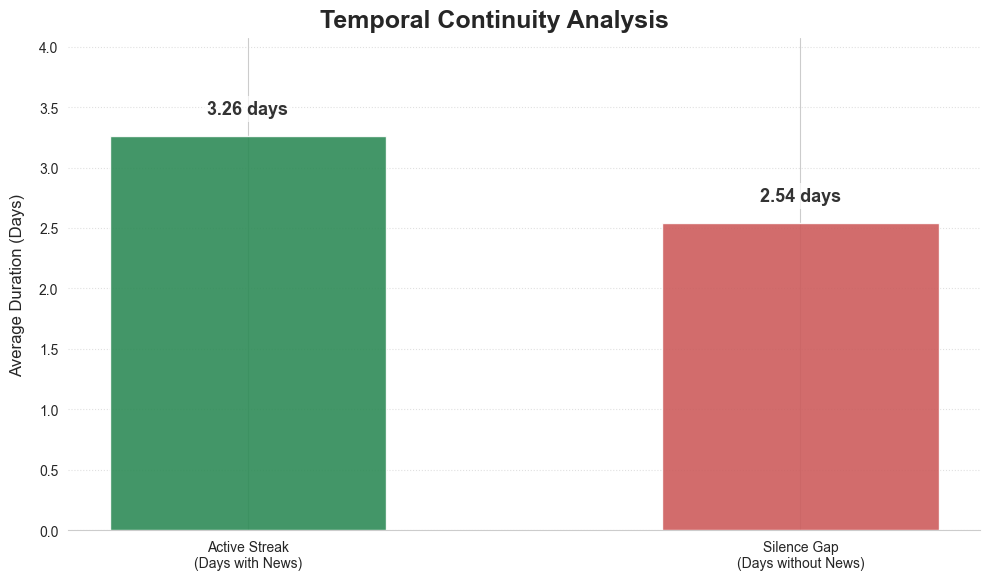

In [16]:
# --- CONFIGURATION ---
client = MongoClient("mongodb://localhost:27017/")
db = client["DM_DB_Integrated"]
collection = db["daily_market_summary"] 

print("\n--- PHASE 6: TEMPORAL DATA QUALITY (Investigative Metrics & Viz) ---")

# 1. LOAD DATA
cursor = collection.find({})
docs = list(cursor)
data_rows = []

for doc in docs:
    date_str = doc.get('date_str') or doc.get('date')
    if not date_str: continue
        
    btc_price = doc.get('prices', {}).get('BTC-USD', {}) or {}
    
    data_rows.append({
        'date': pd.to_datetime(date_str),
        'news_count': doc.get('article_count', 0),
        'volatility': abs(btc_price.get('intraday_change', 0) or 0)
    })

df_ts = pd.DataFrame(data_rows)

if not df_ts.empty:
    df_ts = df_ts.sort_values('date').set_index('date')
    
    # --- METRICS CALCULATION ---
    has_news = df_ts['news_count'] > 0
    streaks = has_news.ne(has_news.shift()).cumsum()
    
    avg_streak = streaks[has_news].value_counts().mean() if has_news.sum() > 0 else 0
    
    no_news = ~has_news
    avg_gap = streaks[no_news].value_counts().mean() if no_news.sum() > 0 else 0
        
    coverage_pct = (has_news.sum() / len(df_ts)) * 100

    print(f"TEMPORAL DQ REPORT: Coverage {coverage_pct:.2f}% | Streak {avg_streak:.2f} | Gap {avg_gap:.2f}")

    # --- PROFESSIONAL VISUALIZATION ---
    # Imposta lo stile grafico
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Dati
    labels = ['Active Streak\n(Days with News)', 'Silence Gap\n(Days without News)']
    values = [avg_streak, avg_gap]
    
    # Palette colori professionale (Verde Smeraldo vs Rosso Mattone desaturato)
    colors = ['#2E8B57', '#CD5C5C'] 
    
    # Disegno delle barre
    bars = plt.bar(labels, values, color=colors, alpha=0.9, width=0.5, zorder=3)
    
    # Aggiunta etichette valori con box
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.15, 
                 f'{height:.2f} days', 
                 ha='center', va='bottom', fontsize=13, fontweight='bold', color='#333333',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=3))

    # Titoli e Sottotitoli
    plt.suptitle('Temporal Continuity Analysis', fontsize=18, fontweight='bold', y=0.96)
    
    plt.ylabel('Average Duration (Days)', fontsize=12, labelpad=10)
    
    # Rimuovi bordi inutili (spine)
    sns.despine(left=True, bottom=False)
    
    # Griglia solo orizzontale (dietro le barre)
    plt.grid(axis='y', linestyle=':', alpha=0.6, zorder=0)
    
    # Margine superiore extra per le etichette
    plt.ylim(0, max(values) * 1.25)
    
    plt.tight_layout()
    plt.show()

else:
    print("TEMPORAL DQ: No data available for analysis.")

In [17]:

print("\n--- PHASE 6: TEMPORAL DATA QUALITY (Investigative Metrics) ---")

# 1. LOAD DATA
cursor = collection.find({})
docs = list(cursor)
data_rows = []

for doc in docs:
    date_str = doc.get('date_str') or doc.get('date')
    if not date_str: continue
        
    btc_price = doc.get('prices', {}).get('BTC-USD', {}) or {}
    
    data_rows.append({
        'date': pd.to_datetime(date_str),
        'news_count': doc.get('article_count', 0),
        'volatility': abs(btc_price.get('intraday_change', 0) or 0)
    })

df_ts = pd.DataFrame(data_rows)

if not df_ts.empty:
    df_ts = df_ts.sort_values('date').set_index('date')
    
    # --- A. TEMPORAL COVERAGE CONTINUITY ---
    # Metric: Continuity of information flow
    has_news = df_ts['news_count'] > 0
    
    # Calculate Streaks (consecutive days with same status)
    # This creates a group ID for every consecutive block of True/False
    streaks = has_news.ne(has_news.shift()).cumsum()
    
    # 1. Positive Streaks (Days WITH news)
    avg_streak = streaks[has_news].value_counts().mean() if has_news.sum() > 0 else 0
    
    # 2. Negative Streaks (Days WITHOUT news - "Gaps")
    no_news = ~has_news
    if no_news.sum() > 0:
        # We calculate the average length of consecutive 'False' blocks
        avg_gap = streaks[no_news].value_counts().mean()
    else:
        avg_gap = 0
        
    coverage_pct = (has_news.sum() / len(df_ts)) * 100

    # --- B. NEWS BURSTINESS ---
    # Metric: Index of Dispersion (Variance / Mean)
    mean_news = df_ts['news_count'].mean()
    var_news = df_ts['news_count'].var()
    burstiness_index = (var_news / mean_news) if mean_news > 0 else 0
    
    # --- C. MARKET-NEWS SYNCHRONIZATION ---
    # Metric: Overlap between Top-K News and Top-K Volatility
    k_percent = 0.10
    n_top = max(1, int(len(df_ts) * k_percent))

    top_news_days = set(df_ts['news_count'].nlargest(n_top).index)
    top_vol_days = set(df_ts['volatility'].nlargest(n_top).index)

    overlap_count = len(top_news_days.intersection(top_vol_days))
    sync_score = (overlap_count / len(top_news_days)) * 100 if len(top_news_days) > 0 else 0

    print(f"TEMPORAL DQ REPORT:")
    print(f"- Days Analyzed: {len(df_ts)}")
    print(f"- Coverage Ratio: {coverage_pct:.2f}% (Days with news)")
    print(f"- Avg News Streak: {avg_streak:.2f} days (Persistence)")
    print(f"- Avg No-News Gap: {avg_gap:.2f} days (Information Holes)")
    print(f"- Burstiness Index: {burstiness_index:.2f} (>1 implies clustered events)")
    print(f"- Synchronization Score: {sync_score:.2f}% (Top {int(k_percent*100)}% overlap)")

    # Save to Report Dictionary (Optional)
    temporal_dq_summary = {
        "coverage_ratio": coverage_pct,
        "avg_streak": avg_streak,
        "avg_gap": avg_gap,
        "burstiness_index": burstiness_index,
        "sync_score": sync_score
    }

else:
    print("TEMPORAL DQ: No data available for analysis.")


--- PHASE 6: TEMPORAL DATA QUALITY (Investigative Metrics) ---
TEMPORAL DQ REPORT:
- Days Analyzed: 2902
- Coverage Ratio: 56.24% (Days with news)
- Avg News Streak: 3.26 days (Persistence)
- Avg No-News Gap: 2.54 days (Information Holes)
- Burstiness Index: 2.33 (>1 implies clustered events)
- Synchronization Score: 17.59% (Top 10% overlap)


In [18]:
print("\n--- PHASE 7: ADVANCED CONTENT METRICS (Semantic Redundancy) ---")

# 1. LOAD DATA
cursor = collection.find({})
docs = list(cursor)

daily_redundancy_scores = []
processed_days = 0
redundant_days_list = [] # List to store details of high redundancy days

vectorizer = TfidfVectorizer(stop_words='english')

print(f"Analyzing {len(docs)} daily documents from 'Article' collection...\n")

for doc in docs:
    # 1. Extract date for reporting
    date_str = doc.get('date_str') or str(doc.get('date'))[:10]
    
    # 2. Extract articles list
    articles_list = doc.get('articles', [])
    
    # We need at least 2 articles to compute similarity
    if len(articles_list) < 2:
        continue
        
    # 3. Extract Texts
    day_texts = []
    for art in articles_list:
        t = art.get('title', '')
        a = art.get('abstract', '')
        full_text = f"{t}. {a}".strip()
        
        if len(full_text) > 15: # Filter out empty/too short texts
            day_texts.append(full_text)
            
    if len(day_texts) < 2:
        continue

    # 4. Calculate Cosine Similarity
    try:
        tfidf_matrix = vectorizer.fit_transform(day_texts)
        sim_matrix = cosine_similarity(tfidf_matrix)
        
        # Calculate average off-diagonal similarity
        n = sim_matrix.shape[0]
        sum_off_diag = np.sum(sim_matrix) - n # Subtract diagonal (self-similarity)
        n_pairs = n * (n - 1)
        
        avg_sim = sum_off_diag / n_pairs
        
        daily_redundancy_scores.append(avg_sim)
        processed_days += 1
        
        # Store high redundancy events (> 0.20 threshold)
        if avg_sim > 0.20:
            redundant_days_list.append({
                'date': date_str,
                'score': avg_sim,
                'article_count': n
            })
        
    except ValueError:
        pass

# 5. AGGREGATE RESULTS
if daily_redundancy_scores:
    global_avg_redundancy = np.mean(daily_redundancy_scores)
else:
    global_avg_redundancy = 0

# Sort the redundant days list by score (descending)
redundant_days_list = sorted(redundant_days_list, key=lambda x: x['score'], reverse=True)

# --- REPORTING ---
print(f"=== CONTENT DATA QUALITY REPORT ===")
print(f"1. Metrics Overview")
print(f"   - Days Analyzed (multi-article): {processed_days}")
print(f"   - Global Redundancy Score:       {global_avg_redundancy:.4f} (Scale 0-1)")
print(f"   (Interpretation: Low score < 0.05 implies high topic diversity.)\n")

print(f"2. High Redundancy Events (Score > 0.20)")
print(f"   - Total Days Found: {len(redundant_days_list)}")

if redundant_days_list:
    print(f"   - Top Redundant Days (Narrative Convergence):")
    print(f"     {'Date':<12} | {'Score':<8} | {'Articles':<5}")
    print(f"     {'-'*30}")
    for item in redundant_days_list:
        print(f"     {item['date']:<12} | {item['score']:.4f}   | {item['article_count']}")
else:
    print("   - No days exceeded the redundancy threshold.")


--- PHASE 7: ADVANCED CONTENT METRICS (Semantic Redundancy) ---
Analyzing 2902 daily documents from 'Article' collection...

=== CONTENT DATA QUALITY REPORT ===
1. Metrics Overview
   - Days Analyzed (multi-article): 910
   - Global Redundancy Score:       0.0214 (Scale 0-1)
   (Interpretation: Low score < 0.05 implies high topic diversity.)

2. High Redundancy Events (Score > 0.20)
   - Total Days Found: 9
   - Top Redundant Days (Narrative Convergence):
     Date         | Score    | Articles
     ------------------------------
     2024-05-13   | 0.4914   | 9
     2021-11-29   | 0.3990   | 2
     2022-03-18   | 0.3499   | 7
     2023-03-11   | 0.2655   | 2
     2024-06-03   | 0.2639   | 2
     2021-06-05   | 0.2435   | 2
     2022-08-15   | 0.2357   | 2
     2024-07-28   | 0.2121   | 2
     2019-06-18   | 0.2017   | 3


### Query:

In [7]:
# Connection
client = MongoClient("mongodb://localhost:27017/")

db = client["DM_DB_Integrated"] 
collection = db["daily_market_summary"]

# Function to Print the query output
def run_query(pipeline, title):
    print(f"\n=== {title} ===")
    results = list(collection.aggregate(pipeline))
    if not results:
        print("No result.")
        return
    
    df = pd.DataFrame(results)

    if '_id' in df.columns: del df['_id']
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(df)

In [ ]:
pipeline_1 = [
    # 1. Sort for article_count (desc)
    { "$sort": { "article_count": -1 } },
    
    # 2. First 5 days
    { "$limit": 5 },
    
    # 3. Select what we want to show
    {
        "$project": {
            "date": "$date_str",
            "#articles": "$article_count",
            "title": "$articles.title", 
            
            # Bitcoin Data
            "btc_open": "$prices.BTC-USD.open",
            "btc_close": "$prices.BTC-USD.close",
            "btc_volatility_intraday": "$prices.BTC-USD.intraday_change",
            "btc_volatility_next_week": "$prices.BTC-USD.future_trend.next_week_diff",
            
            # Ethereum Data
            "eth_open": "$prices.ETH-USD.open",
            "eth_close": "$prices.ETH-USD.close",
            "eth_volatility_intraday": "$prices.ETH-USD.intraday_change",
            "eth_volatility_next_week": "$prices.ETH-USD.future_trend.next_week_diff"
        }
    }
]

run_query(pipeline_1, "Day with most article count + Trend (BTC & ETH)")



=== Day with most article count + Trend (BTC & ETH) ===
         date  #articles                                              title      btc_open     btc_close  btc_volatility_intraday  btc_volatility_next_week     eth_open    eth_close  eth_volatility_intraday  eth_volatility_next_week
0  2022-12-13         15  [In FTX Collapse, Binance Sees a Chance to Bec...  17206.441406  17781.318359               574.876953               -875.013672  1274.662476  1320.549194                45.886719               -102.845581
1  2022-11-30         13  [Before FTX fell apart, Sam Bankman-Fried was ...  16445.476562  17168.566406               723.089844               -320.439453  1216.928711  1295.688599                78.759888                -63.251099
2  2018-06-28         13  [A Field Guide to the Hurdles Facing Blockchai...   6153.160156   5903.439941              -249.720215                735.700195   442.290009   422.364990               -19.925018                 52.046997
3  2021-05-13  

In [6]:
pipeline_recovery = [
    {
        # Focus on days where BTC dropped significantly (Intraday < -50)
        "$match": { "prices.BTC-USD.intraday_change": { "$lt": -50 } }
    },
    {
        "$project": {
            "Date": "$date_str",
            "Articles": "$article_count",
            
            # --- Bitcoin Analysis ---
            "BTC_Crash_Amount": { "$subtract": ["$prices.BTC-USD.close", "$prices.BTC-USD.context.close_prev_week"] },
            "BTC_Immediate_Recovery_24h": "$prices.BTC-USD.future_trend.next_day_diff",
            "BTC_Weekly_Recovery_7d": "$prices.BTC-USD.future_trend.next_week_diff",
            "BTC_Recovery_Type": {
                "$switch": {
                    "branches": [
                        { "case": { "$gt": ["$prices.BTC-USD.future_trend.next_day_diff", 0] }, "then": "V-Shape (Fast)" },
                        { "case": { "$gt": ["$prices.BTC-USD.future_trend.next_week_diff", 0] }, "then": "U-Shape (Slow)" }
                    ],
                    "default": "No Recovery"
                }
            },

            # --- Ethereum Analysis ---
            "ETH_Crash_Amount": { "$subtract": ["$prices.ETH-USD.close", "$prices.ETH-USD.context.close_prev_week"] },
            "ETH_Immediate_Recovery_24h": "$prices.ETH-USD.future_trend.next_day_diff",
            "ETH_Weekly_Recovery_7d": "$prices.ETH-USD.future_trend.next_week_diff",
            "ETH_Recovery_Type": {
                "$switch": {
                    "branches": [
                        { "case": { "$gt": ["$prices.ETH-USD.future_trend.next_day_diff", 0] }, "then": "V-Shape (Fast)" },
                        { "case": { "$gt": ["$prices.ETH-USD.future_trend.next_week_diff", 0] }, "then": "U-Shape (Slow)" }
                    ],
                    "default": "No Recovery"
                }
            }
        }
    },
    { "$sort": { "BTC_Crash_Amount": 1 } }, # Show biggest BTC crashes first
    { "$limit": 10 }
]

run_query(pipeline_recovery, "CRASH & RECOVERY ANALYSIS (BTC vs ETH)")



=== CRASH & RECOVERY ANALYSIS (BTC vs ETH) ===
         Date  Articles  BTC_Crash_Amount  BTC_Immediate_Recovery_24h  BTC_Weekly_Recovery_7d BTC_Recovery_Type  ETH_Crash_Amount  ETH_Immediate_Recovery_24h  ETH_Weekly_Recovery_7d ETH_Recovery_Type
0  2018-01-01         1               NaN                 1324.899414             1512.899414    V-Shape (Fast)               NaN                  111.802979              375.889038    V-Shape (Fast)
1  2018-01-07         1               NaN                -1307.500000            -2705.599609       No Recovery               NaN                   -4.640015              213.599976    U-Shape (Slow)
2  2025-11-17        11     -13902.718750                  855.000000            -3823.312500    V-Shape (Fast)       -543.921143                   98.440186              -71.825439    V-Shape (Fast)
3  2021-05-18         4     -13795.171875                -5906.960938            -4507.179688       No Recovery       -788.631104                 -919.3

In [4]:
pipeline_2 = [
    # 1. Day with articles and where the price (bitcoin) decrease (next day)
    { 
        "$match": { 
            "article_count": { "$gt": 0 },
            "prices.BTC-USD.future_trend.next_day_diff": { "$lt": 0 } 
        } 
    },
    # 2. Sort by the biggest Bitcoin drop (ascending because values are negative)
    { "$sort": { "prices.BTC-USD.future_trend.next_day_diff": 1 } }, 
    { "$limit": 5 },
    {
        "$project": {
            "date_article": "$date_str",
            "news_count": "$article_count",
            "title": { "$arrayElemAt": ["$articles.title", 0] }, # First article title
            
            # Bitcoin Data
            "btc_price_close": "$prices.BTC-USD.close",
            "btc_loss_next_day": "$prices.BTC-USD.future_trend.next_day_diff",
            "btc_next_week_diff": "$prices.BTC-USD.future_trend.next_week_diff",
            
            
        }
    }
]

run_query(pipeline_2, "2. Top 5 collapse after an article (BTC vs ETH)")



=== 2. Top 5 collapse after an article (BTC vs ETH) ===
  date_article  news_count                                              title  btc_price_close  btc_loss_next_day  btc_next_week_diff
0   2025-10-09           1  Crypto Investor Known as ‘Bitcoin Jesus’ Reach...    121705.585938       -8491.218750       -13519.546875
1   2025-03-02           1           Is ‘Wicked’ Really a Resistance Musical?     94248.351562       -8182.679688       -13647.312500
2   2021-05-11           1       L Brands Plans to Spin Off Victoria’s Secret     56704.574219       -7554.039062       -13795.171875
3   2024-12-17           3  Late Night Delights in Pie-in-the-Sky Theories...    106140.601562       -6099.062500        -7464.507812
4   2021-05-18           4  Elon Musk Impostors Scammed $2 Million in Cryp...     42909.402344       -5906.960938        -4507.179688


In [6]:
pipeline_2 = [
    # 1. Day with articles and where the price (bitcoin) decrease (next day)
    { 
        "$match": { 
            "article_count": { "$gt": 0 },
            "prices.ETH-USD.future_trend.next_day_diff": { "$lt": 0 } 
        } 
    },
    # 2. Sort by the biggest Bitcoin drop (ascending because values are negative)
    { "$sort": { "prices.ETH-USD.future_trend.next_day_diff": 1 } }, 
    { "$limit": 5 },
    {
        "$project": {
            "date_article": "$date_str",
            "news_count": "$article_count",
            "title": { "$arrayElemAt": ["$articles.title", 0] }, # First article title
            
            # Ethereum Data:
            "eth_price_close": "$prices.ETH-USD.close",
            "eth_loss_next_day": "$prices.ETH-USD.future_trend.next_day_diff",
            "eth_next_week_diff": "$prices.ETH-USD.future_trend.next_week_diff"
            
            
        }
    }
]

run_query(pipeline_2, "2. Top 5 collapse after an article (BTC vs ETH)")


=== 2. Top 5 collapse after an article (BTC vs ETH) ===
  date_article  news_count                                              title  eth_price_close  eth_loss_next_day  eth_next_week_diff
0   2021-05-18           4  Elon Musk Impostors Scammed $2 Million in Cryp...      3380.070068        -919.390869         -673.441162
1   2025-10-09           1  Crypto Investor Known as ‘Bitcoin Jesus’ Reach...      4369.143555        -526.134766         -474.389160
2   2021-09-06           1  The Strange Tale of the Freedom Phone, a Smart...      3928.379395        -501.985107         -642.867676
3   2022-01-20           6  Eric Adams, a Bitcoin Booster, Is Taking First...      3001.120117        -443.188477         -578.118896
4   2021-05-14           6  He’s a Dogecoin Millionaire. And He’s Not Sell...      4079.057373        -440.935303        -1648.436035


In [7]:
pipeline_3 = [
    {
        "$group": {
            "_id": { 
                # Conditional logic to label groups
                "$cond": [{ "$gt": ["$article_count", 0] }, "Days WITH News", "Days WITHOUT News"] 
            },
            "total_days": { "$sum": 1 },
            
            # Calculate absolute variation mean for Bitcoin
            "btc_avg_abs_volatility": { "$avg": { "$abs": "$prices.BTC-USD.intraday_change" } },
            
            # Calculate absolute variation mean for Ethereum
            "eth_avg_abs_volatility": { "$avg": { "$abs": "$prices.ETH-USD.intraday_change" } }
        }
    },
    {
        "$project": {
            "_id": 0,                     # Hide the default MongoDB ID field
            "Category": "$_id",           # Move the label to a column named 'Category'
            "total_days": 1,              # Keep this column
            "btc_avg_abs_volatility": 1,  # Bitcoin Volatility
            "eth_avg_abs_volatility": 1   # Ethereum Volatility
        }
    }
]

run_query(pipeline_3, "3. Volatility Analysis (BTC vs ETH)")



=== 3. Volatility Analysis (BTC vs ETH) ===
   total_days  btc_avg_abs_volatility  eth_avg_abs_volatility           Category
0        1270              474.026571               28.651681  Days WITHOUT News
1        1632              982.909538               65.524399     Days WITH News


In [ ]:
pipeline_blind_risk = [

    # 1. Blind spot: zero articles + BTC move
    {
        "$match": {
            "article_count": 0,
            "prices.BTC-USD.intraday_change": { "$exists": True }
        }
    },

    # 2. Volatility + Time windows (±3 days)
    {
        "$addFields": {
            "btc_abs_volatility": {
                "$abs": "$prices.BTC-USD.intraday_change"
            },
            "start_3d_before": {
                "$subtract": ["$date", 3 * 24 * 60 * 60 * 1000]
            },
            "end_3d_after": {
                "$add": ["$date", 3 * 24 * 60 * 60 * 1000]
            }
        }
    },

    # 3. Lookup: 3 days BEFORE
    {
        "$lookup": {
            "from": "daily_market_summary",
            "let": {
                "start": "$start_3d_before",
                "blind": "$date"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gte": ["$date", "$$start"] },
                                { "$lt": ["$date", "$$blind"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "total_articles": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_before"
        }
    },

    # 4. Lookup: 3 days AFTER
    {
        "$lookup": {
            "from": "daily_market_summary",
            "let": {
                "blind": "$date",
                "end": "$end_3d_after"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gt": ["$date", "$$blind"] },
                                { "$lte": ["$date", "$$end"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "total_articles": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_after"
        }
    },

    # 5. Flatten lookup results
    {
        "$addFields": {
            "articles_3d_pre": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_before.total_articles", 0] },
                    0
                ]
            },
            "articles_3d_post": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_after.total_articles", 0] },
                    0
                ]
            }
        }
    },

    # 6. Sort by risk (volatility)
    { "$sort": { "btc_abs_volatility": -1 } },
    { "$limit": 5 },

    # 7. Final Output
    {
        "$project": {
            "_id": 0,
            "date": "$date_str",

            "articles_today": "$article_count",
            "articles_3d_pre": 1,
            "articles_3d_post": 1,

            # Bitcoin Data
            "btc_open": "$prices.BTC-USD.open",
            "btc_close": "$prices.BTC-USD.close",
            "btc_daily_change": "$prices.BTC-USD.intraday_change",
            "btc_absolute_volatility": "$btc_abs_volatility",
            "btc_future_weekly_change": "$prices.BTC-USD.future_trend.next_week_diff",

            # Ethereum Data
            "eth_open": "$prices.ETH-USD.open",
            "eth_close": "$prices.ETH-USD.close",
            "eth_daily_change": "$prices.ETH-USD.intraday_change",
            "eth_future_weekly_change": "$prices.ETH-USD.future_trend.next_week_diff"
        }
    }
]

run_query(
    pipeline_blind_risk,
    "Blind Spot ±3 days (News vacuum + Volatility) [BTC & ETH]"
)



=== Blind Spot ±3 days (News vacuum + Volatility) [BTC & ETH] ===
   articles_3d_pre  articles_3d_post        date  articles_today       btc_open      btc_close  btc_daily_change  btc_absolute_volatility  btc_future_weekly_change     eth_open    eth_close  eth_daily_change  eth_future_weekly_change
0                5                 3  2021-11-26               0   58960.285156   53569.765625      -5390.519531              5390.519531                 28.480469  4522.208984  4030.908936       -491.300049                189.797119
1                2                 8  2025-04-06               0   83504.507812   78214.484375      -5290.023438              5290.023438               5470.492188  1805.963013  1576.728027       -229.234985                 19.957764
2                7                 8  2025-11-04               0  106541.421875  101590.523438      -4950.898438              4950.898438               1406.945312  3602.040771  3292.574463       -309.466309                122.7077

In [11]:
pipeline_blind_risk = [

    # 1. Blind spot: zero articles + BTC move
    {
        "$match": {
            "prices.BTC-USD.intraday_change": { "$exists": True }
        }
    },

    # 2. Volatility + Time windows (±3 days)
    {
        "$addFields": {
            "btc_abs_volatility": {
                "$abs": "$prices.BTC-USD.intraday_change"
            },
            "start_3d_before": {
                "$subtract": ["$date", 3 * 24 * 60 * 60 * 1000]
            },
            "end_3d_after": {
                "$add": ["$date", 3 * 24 * 60 * 60 * 1000]
            }
        }
    },

    # 3. Lookup: 3 days BEFORE
    {
        "$lookup": {
            "from": "daily_market_summary",
            "let": {
                "start": "$start_3d_before",
                "blind": "$date"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gte": ["$date", "$$start"] },
                                { "$lt": ["$date", "$$blind"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "total_articles": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_before"
        }
    },

    # 4. Lookup: 3 days AFTER
    {
        "$lookup": {
            "from": "daily_market_summary",
            "let": {
                "blind": "$date",
                "end": "$end_3d_after"
            },
            "pipeline": [
                {
                    "$match": {
                        "$expr": {
                            "$and": [
                                { "$gt": ["$date", "$$blind"] },
                                { "$lte": ["$date", "$$end"] }
                            ]
                        }
                    }
                },
                {
                    "$group": {
                        "_id": None,
                        "total_articles": { "$sum": "$article_count" }
                    }
                }
            ],
            "as": "days_after"
        }
    },

    # 5. Flatten lookup results
    {
        "$addFields": {
            "articles_3d_pre": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_before.total_articles", 0] },
                    0
                ]
            },
            "articles_3d_post": {
                "$ifNull": [
                    { "$arrayElemAt": ["$days_after.total_articles", 0] },
                    0
                ]
            }
        }
    },

    # 6. Sort by risk (volatility)
    { "$sort": { "btc_abs_volatility": -1 } },
    { "$limit": 5 },

    # 7. Final Output
    {
        "$project": {
            "_id": 0,
            "date": "$date_str",

            "articles_today": "$article_count",
            "articles_3d_pre": 1,
            "articles_3d_post": 1,

            # Bitcoin Data
            "btc_open": "$prices.BTC-USD.open",
            "btc_close": "$prices.BTC-USD.close",
            "btc_daily_change": "$prices.BTC-USD.intraday_change",
            "btc_abs_volatility": "$btc_abs_volatility",
            "btc_future_weekly_change": "$prices.BTC-USD.future_trend.next_week_diff",

            # Ethereum Data
            "eth_open": "$prices.ETH-USD.open",
            "eth_close": "$prices.ETH-USD.close",
            "eth_daily_change": "$prices.ETH-USD.intraday_change",
            "eth_future_weekly_change": "$prices.ETH-USD.future_trend.next_week_diff"
        }
    }
]

run_query(
    pipeline_blind_risk,
    "Blind Spot ±3 days Days with news (Volatility) [BTC & ETH]"
)



=== Blind Spot ±3 days Days with news (Volatility) [BTC & ETH] ===
   articles_3d_pre  articles_3d_post        date  articles_today       btc_open      btc_close  btc_daily_change  btc_abs_volatility  btc_future_weekly_change     eth_open    eth_close  eth_daily_change  eth_future_weekly_change
0                3                 5  2025-10-10               3  121704.742188  113214.367188      -8490.375000         8490.375000              -6746.578125  4369.065430  3843.008789       -526.056641                -10.449951
1                4                11  2024-11-11               4   80471.414062   88701.484375       8230.070312         8230.070312               1841.156250  3191.656982  3374.812988        183.156006               -166.956543
2               12                 5  2025-03-02               1   86036.257812   94248.351562       8212.093750         8212.093750             -13647.312500  2216.521729  2519.694580        303.172852               -504.185425
3               

In [38]:
# not important
pipeline_4 = [
    {
        "$match": {
            "article_count": { "$gt": 0 },
            
            # Filter for positive future trends (next week)
            "prices.ETH-USD.future_trend.next_week_diff": { "$gt": 0 }
        }
    },
    { "$sort": { "prices.ETH-USD.future_trend.next_week_diff": -1 } }, # Highest gains
    { "$limit": 5 },
    {
        "$project": {
            "date": "$date_str",
            "news": { "$arrayElemAt": ["$articles.title", 0] },
            "eth_close_today": "$prices.ETH-USD.close",
            "gain_after_7days": "$prices.ETH-USD.future_trend.next_week_diff"
        }
    }
]

run_query(pipeline_4, "4. News followed by a weekly Bull Run (ETH)")


=== 4. News followed by a weekly Bull Run (ETH) ===
         date                                               news  eth_close_today  gain_after_7days
0  2025-08-06  On the Hunt for Spies, Iran Executes a Nuclear...      3683.920654       1072.355225
1  2025-08-05  What Talks With India and Switzerland Say Abou...      3611.899414        979.025391
2  2024-11-04        A November Surprise Is Jostling the Markets      2397.026367        977.786621
3  2021-05-01    Digital Horses Are the Talk of the Crypto World      2945.892822        956.754883
4  2024-05-14  Biden Bans Chinese Bitcoin Mine Near U.S. Nucl...      2881.157959        908.154785


## EDA:

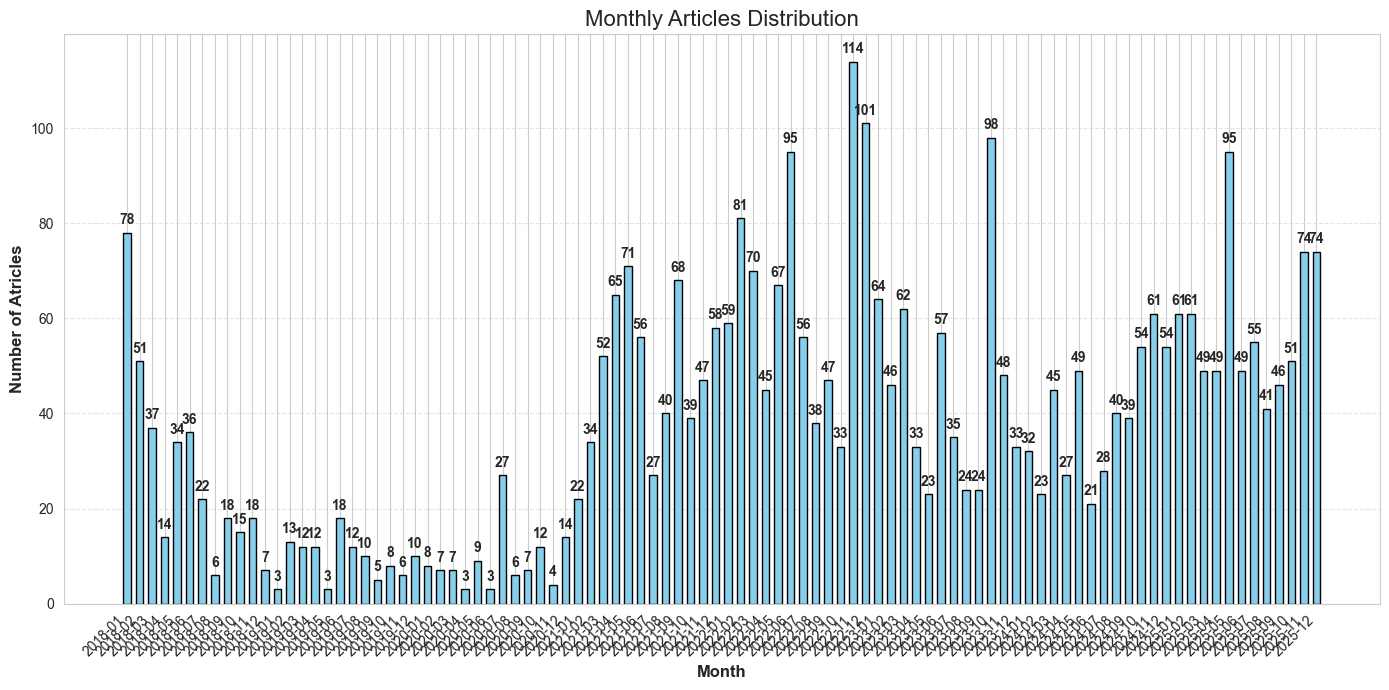

In [23]:
# 1. Connection
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

# 2. Data retrival
projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato! Assicurati di aver popolato il DB con il nuovo script.")
else:
    # 3. Dataframe preparation
    df = pd.DataFrame(data)
    
    # pub_date exist?
    if 'pub_date' not in df.columns:
        print("ERRORE: Il campo 'pub_date' non è stato trovato nei documenti.")
        print("Esempio di documento nel DB:", collection.find_one())
    else:
        # conversion 
        df['data'] = pd.to_datetime(df['pub_date'], errors='coerce')
        
        df = df.dropna(subset=['data'])

        # month group by
        df['mese_anno'] = df['data'].dt.to_period('M')
        conteggio_mensile = df['mese_anno'].value_counts().sort_index()

        mesi = conteggio_mensile.index.strftime('%Y-%m') 
        conteggi = conteggio_mensile.values

        # 4. plotting
        plt.figure(figsize=(14, 7)) 
        
        plt.bar(mesi, conteggi, color='skyblue', edgecolor='black', width=0.6)

        plt.xlabel('Month', fontsize=12, fontweight='bold')
        plt.ylabel('Number of Atricles', fontsize=12, fontweight='bold')
        plt.title('Monthly Articles Distribution', fontsize=16)
        
        # X
        plt.xticks(
            rotation=45, 
            ha='right', 
            fontsize=10 
        )
        
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        for i, v in enumerate(conteggi):
            plt.text(i, v + (max(conteggi)*0.01), str(v), ha='center', va='bottom', fontweight='bold')

        plt.subplots_adjust(bottom=0.2)
        plt.tight_layout()
        plt.show()

client.close()

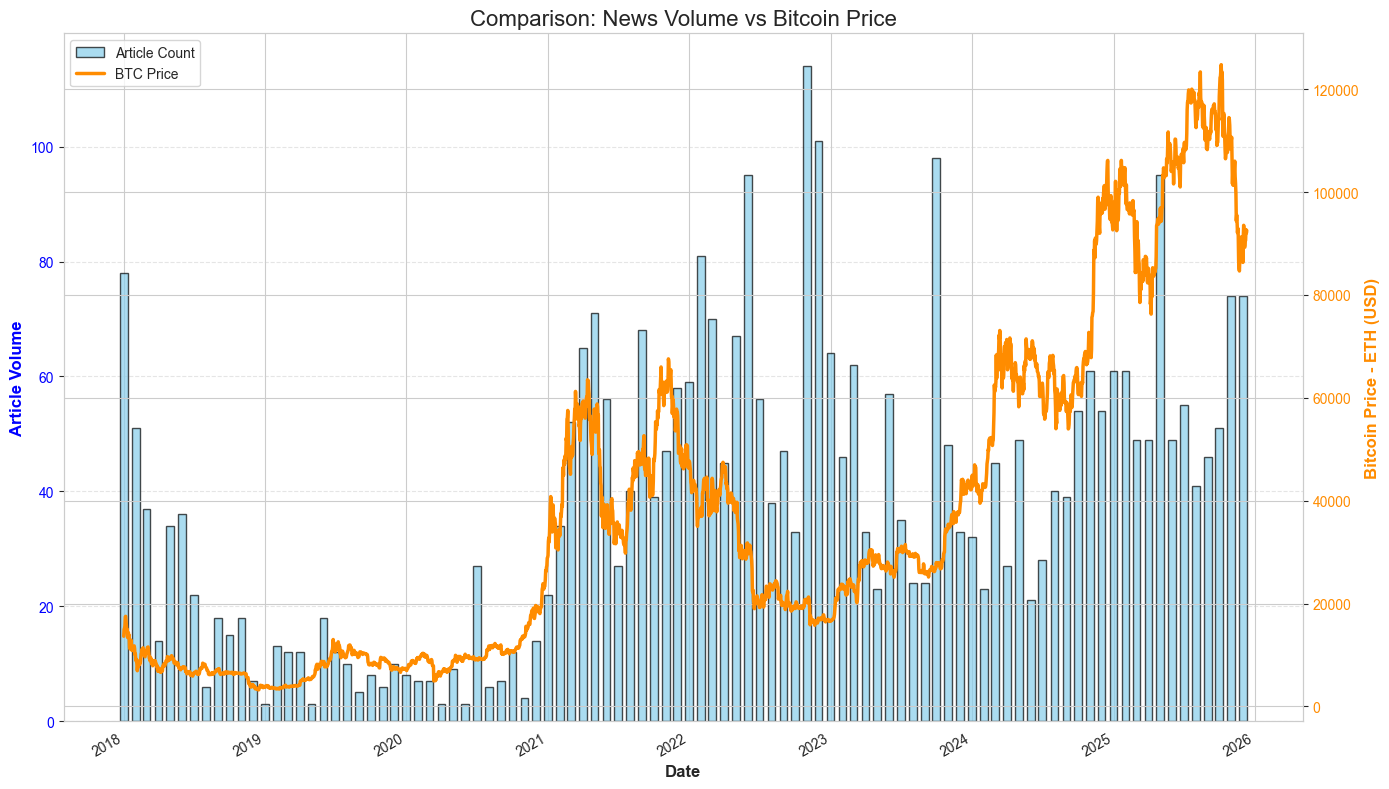

In [26]:

# --- 1. BITCOIN DATA PREPARATION (df_btc) ---
# Ensure 'df_btc' is loaded. If not, create a placeholder.
if 'df' not in locals():
    print("WARNING: 'df_btc' not found. Please load it first (e.g., with yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy()  # Work on a copy

# Ensure the index is datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filter from 2018 onwards for consistency
    df_btc_filtered = df_btc[df_btc.index >= '2018-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. ARTICLE DATA RETRIEVAL (YOUR WORKING CODE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("No data found in MongoDB!")
else:
    # Create DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversion and Cleaning
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Time filter (optional, to align with BTC chart)
        df_articles = df_articles[df_articles['data'] >= '2018-01-01']

        # Group by month
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** IMPORTANT TRICK ***
        # Convert the index (Period) to Timestamp (start of month)
        # This allows Matplotlib to correctly overlay the Bitcoin line
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERATE COMBINED CHART ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # LEFT Y-AXIS (BARS - ARTICLES)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='Article Count')
        
        ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Article Volume', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # RIGHT Y-AXIS (LINE - BITCOIN PRICE)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00'  # Bitcoin Orange
            color_line2 = "#00FF0D" # Eth Green
            color_line3 = "#D400FF"
            
            # Safe handling of the Close column
            try:
                # Try standard access or MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzoeth = df_btc_filtered['Close']['ETH-USD'] if 'ETH-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzosp = df_btc_filtered['Close']['^GSPC'] if '^GSPC' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Hard fallback to the first column
            
            ax2.plot(df_btc_filtered.index, prezzo, color=color_line, linewidth=2.5, label='BTC Price')


            ax2.set_ylabel('Bitcoin Price - ETH (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Unified Legend
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Comparison: News Volume vs Bitcoin Price', fontsize=16)
        fig.autofmt_xdate() # Format X-axis dates
        plt.tight_layout()
        plt.show()

    else:
        print("Error: 'pub_date' column not found in DataFrame.")

client.close()

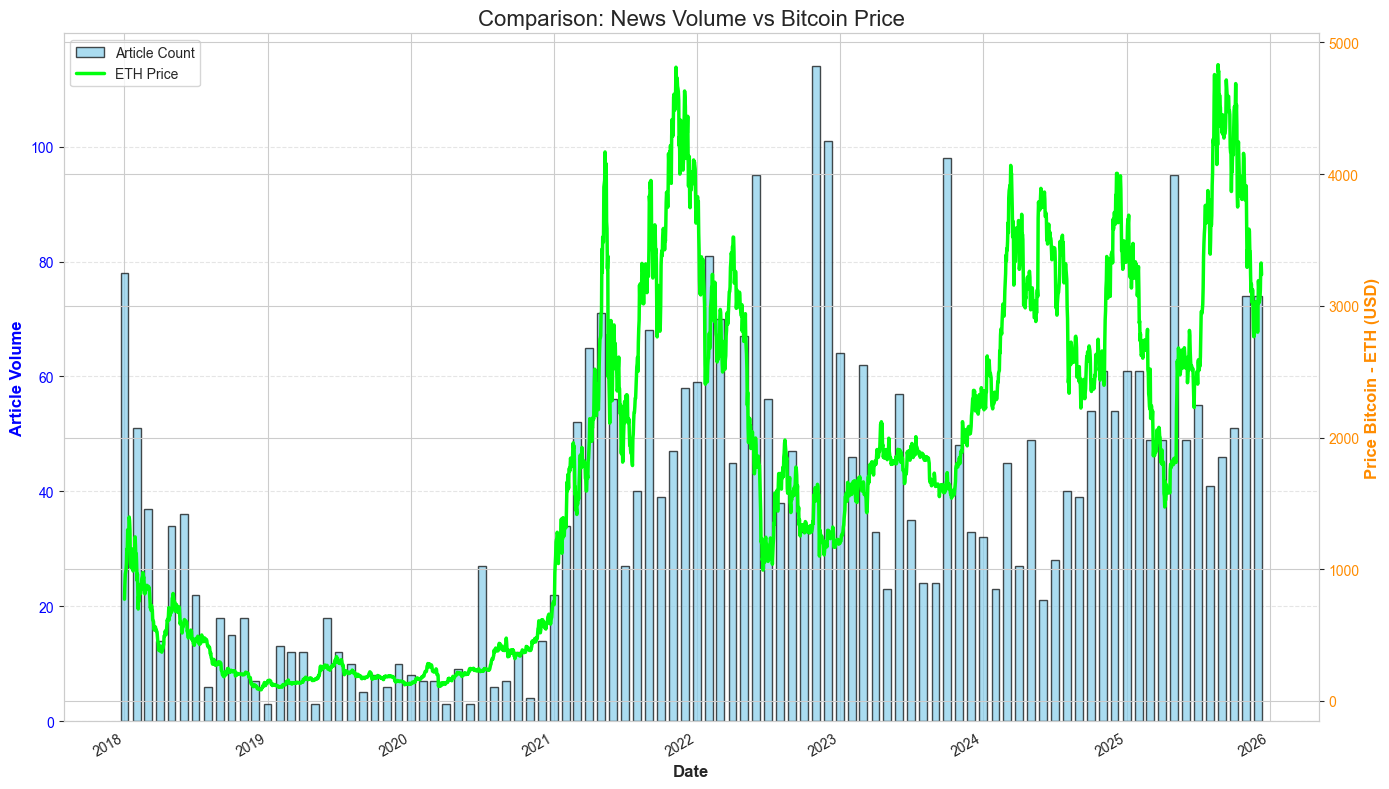

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

# --- 1. BITCOIN DATA PREPARATION (df_btc) ---
# Ensure 'df_btc' is loaded. If not, create a placeholder.
if 'df' not in locals():
    print("WARNING: 'df_btc' not found. Please load it first (e.g., with yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Work on a copy

# Ensure the index is datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filter from 2018 onwards for consistency
    df_btc_filtered = df_btc[df_btc.index >= '2018-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. ARTICLE DATA RETRIEVAL (YOUR WORKING CODE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['project_def2']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("No data found in MongoDB!")
else:
    # Create DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversion and Cleaning
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Time filter (optional, to align with BTC chart)
        df_articles = df_articles[df_articles['data'] >= '2018-01-01']

        # Group by month
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** IMPORTANT TRICK ***
        # Convert the index (Period) to Timestamp (start of month)
        # This allows Matplotlib to correctly overlay the Bitcoin line
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERATE COMBINED CHART ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # LEFT Y-AXIS (BARS - ARTICLES)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='Article Count')
        
        ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Article Volume', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # RIGHT Y-AXIS (LINE - BITCOIN PRICE)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Bitcoin Orange
            color_line2 = "#00FF0D" # Eth Green
            color_line3 = "#D400FF"
            
            # Safe handling of the Close column
            try:
                # Try standard access or MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzoeth = df_btc_filtered['Close']['ETH-USD'] if 'ETH-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
                prezzosp = df_btc_filtered['Close']['^GSPC'] if '^GSPC' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Hard fallback to the first column
            
            # Note: You are plotting ETH price here
            ax2.plot(df_btc_filtered.index, prezzoeth, color=color_line2, linewidth=2.5, label='ETH Price')

            ax2.set_ylabel('Price Bitcoin - ETH (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Unified Legend
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Comparison: News Volume vs Bitcoin Price', fontsize=16)
        fig.autofmt_xdate() # Format X-axis dates
        plt.tight_layout()
        plt.show()

    else:
        print("Error: 'pub_date' column not found in DataFrame.")

client.close()

#### Wordcloud per day:

✅ Data extracted for: ['2019-06-18', '2022-03-18', '2024-05-13']

📅 DATE: 2024-05-13
📊 KNOWN REDUNDANCY SCORE: 0.4914 (Articles: 9)


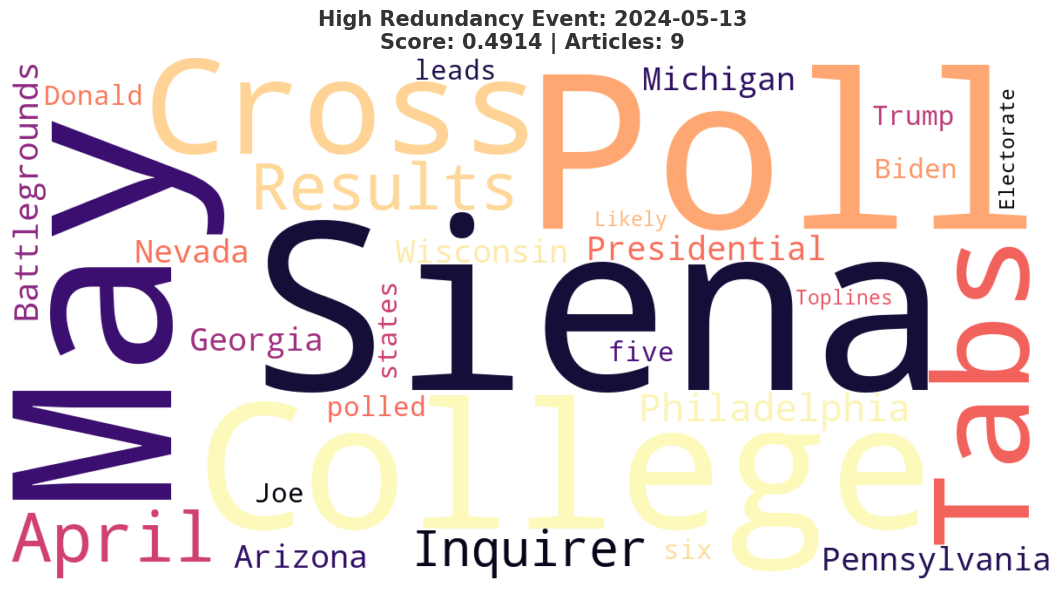



📅 DATE: 2022-03-18
📊 KNOWN REDUNDANCY SCORE: 0.3499 (Articles: 7)


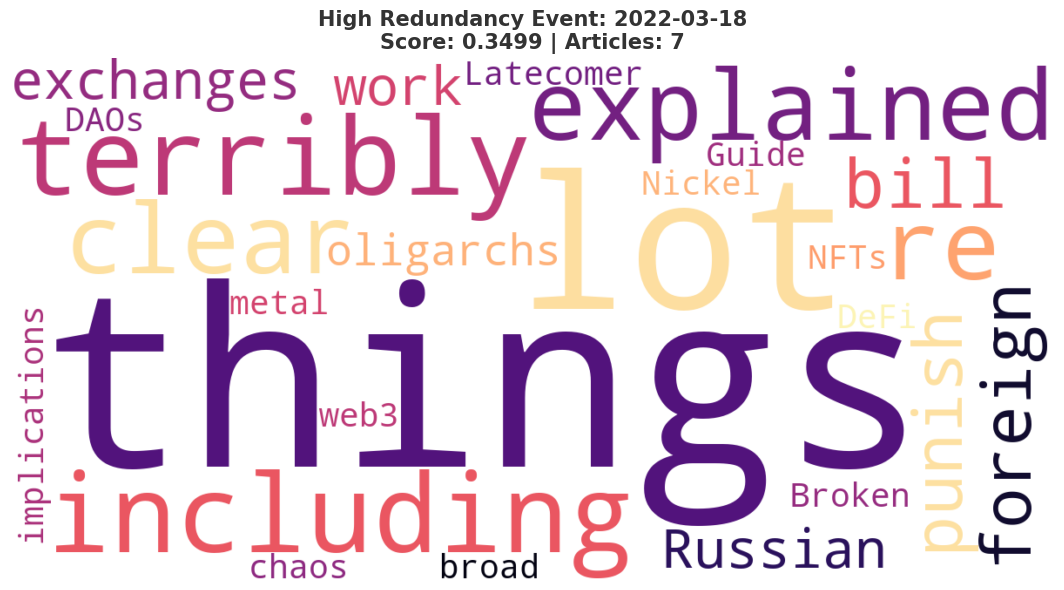



📅 DATE: 2019-06-18
📊 KNOWN REDUNDANCY SCORE: 0.2017 (Articles: 3)


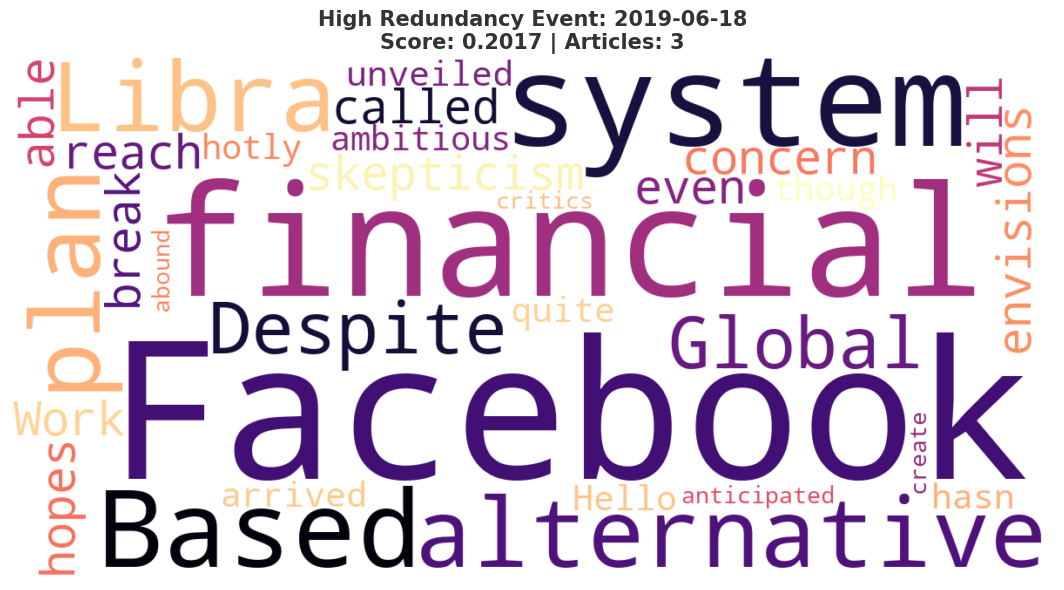

In [ ]:
# Connection
client = MongoClient("mongodb://localhost:27017/")

db = client["DM_DB_Integrated"] 

collection = db["daily_market_summary"]
data = db["daily_market_summary"].find()
# --- 1. CONFIGURATION: METADATA & STOPWORDS ---

# We hardcode the scores from your provided table to save computation time
# Format: 'YYYY-MM-DD': Redundancy Score
target_metadata = {
    "2024-05-13": 0.4914,  # 9 Articles
    "2022-03-18": 0.3499,  # 7 Articles
    "2019-06-18": 0.2017   # 3 Articles
}

# Aggressive stopword list (Journalism noise + Generic Finance terms)
custom_stopwords_b = set(STOPWORDS)
custom_stopwords_b.update([
    # Journalism / NYT Noise
    "new", "york", "times", "briefing", "daily", "today", "week", "year", "month",
    "mr", "ms", "mrs", "said", "say", "says", "reporting", "source", "according",
    "editor", "image", "photo", "credit", "getty", "images", "written", "morning",
    "evening", "posted", "updated", "associated", "press", "dealbook", "newsletter",
    "s", "c", "e", "a", "t", "m", "b", "r",
    
    # Generic Crypto/Finance Terms (allowing specific events to shine)
    "bitcoin", "crypto", "cryptocurrency", "digital", "currency", "market", 
    "price", "value", "investor", "money", "asset", "industry", "company",
    "trading", "exchange", "stock", "stocks"
])

# --- 2. DATA EXTRACTION ---
# Efficiently retrieve only the articles for the 3 target days
selected_days_content = {}

for doc in data:
    # Handle date format safely
    date_raw = doc.get('date_str') or doc.get('date')
    date_str = str(date_raw)[:10] 
    
    if date_str in target_metadata:
        articles = doc.get('articles', [])
        if articles:
            if date_str not in selected_days_content:
                selected_days_content[date_str] = []
            selected_days_content[date_str].extend(articles)

print(f"Data extracted for: {list(selected_days_content.keys())}\n")

# --- 3. VISUALIZATION LOOP ---

for date_str, pre_calc_score in target_metadata.items():
    
    # Check if we actually found articles for this date
    if date_str not in selected_days_content:
        print(f"Warning: No articles found in 'data' for {date_str}")
        continue
        
    articles = selected_days_content[date_str]
    total_articles = len(articles)
    
    # Prepare single text blob for WordCloud
    full_text_blob = ""
    for art in articles:
        t = art.get('title', '') or ""
        a = art.get('abstract', '') or ""
        full_text_blob += f" {t}. {a}"
    
    print("="*60)
    print(f"DATE: {date_str}")
    print(f"KNOWN REDUNDANCY SCORE: {pre_calc_score} (Articles: {total_articles})")

    # Generate WordCloud
    if full_text_blob.strip():
        wc = WordCloud(
            width=1200, 
            height=600, 
            background_color='white', 
            stopwords=custom_stopwords_b, 
            colormap='magma', 
            max_words=50, 
            collocations=False # Avoid repeating bigrams
        ).generate(full_text_blob)
        
        # Plotting
        plt.figure(figsize=(12, 6))
        plt.imshow(wc, interpolation='bilinear')
        
        # Title uses the pre-calculated score from your table
        plt.title(
            f"High Redundancy Event: {date_str}\nScore: {pre_calc_score} | Articles: {total_articles}", 
            fontsize=15, 
            fontweight='bold',
            color='#333333'
        )
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough text content.")
    
    print("\n")

✅ Found top 3 days by volume: [datetime.datetime(2022, 12, 13, 0, 0), datetime.datetime(2018, 6, 28, 0, 0), datetime.datetime(2022, 11, 30, 0, 0)]

📅 DATE: 2022-12-13 00:00:00 | 📚 VOLUME: 15 Articles
------------------------------------------------------------
📊 REDUNDANCY SCORE: 0.0578
   Interpretation: 🟢 LOW (Diverse News)


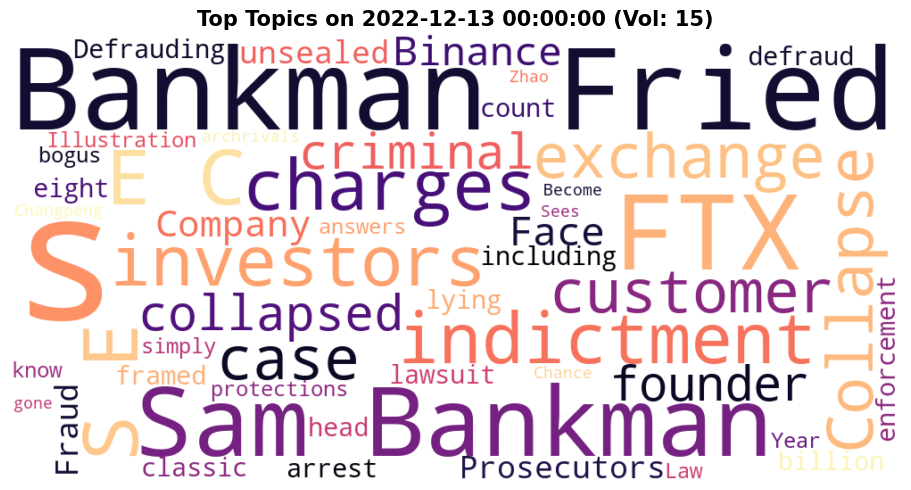



📅 DATE: 2018-06-28 00:00:00 | 📚 VOLUME: 13 Articles
------------------------------------------------------------
📊 REDUNDANCY SCORE: 0.0139
   Interpretation: 🟢 LOW (Diverse News)


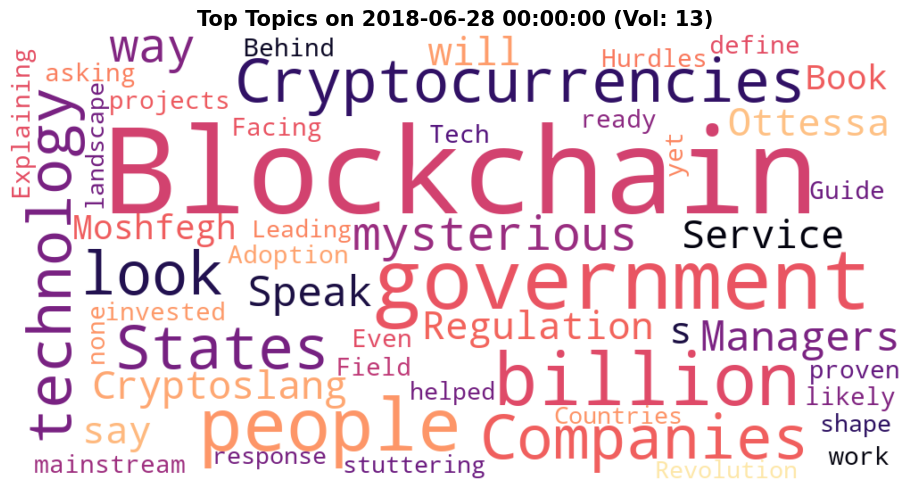



📅 DATE: 2022-11-30 00:00:00 | 📚 VOLUME: 13 Articles
------------------------------------------------------------
📊 REDUNDANCY SCORE: 0.0434
   Interpretation: 🟢 LOW (Diverse News)


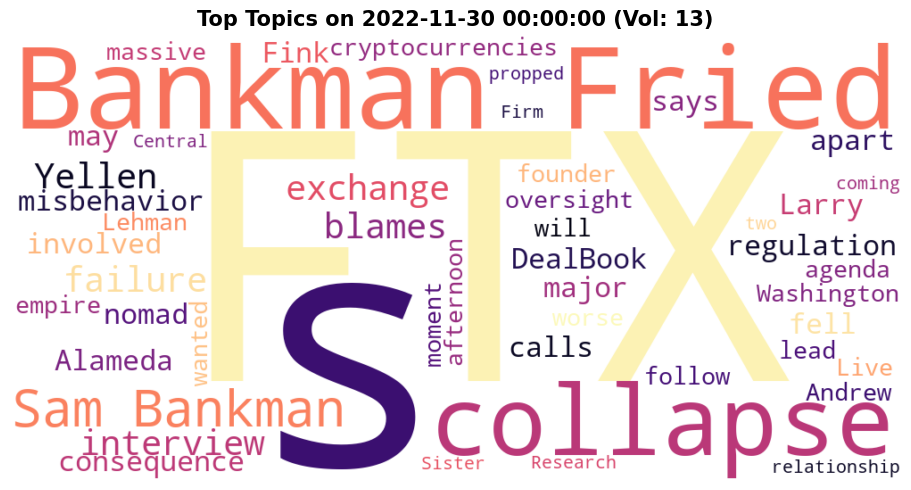

In [ ]:
data = db["daily_market_summary"].find()

# --- 1. DATA PROCESSING: GROUP BY DATE ---
# Organize articles by date to identify the busiest days (Peaks)
days_map = {}

# Iterate through the data (assuming 'data' is your loaded list of dicts)
for doc in data:
    date_str = doc.get('date')
    articles_list = doc.get('articles', [])
    
    
    if date_str and articles_list:
        if date_str not in days_map:
            days_map[date_str] = []
        days_map[date_str].extend(articles_list)

# Convert to a list and find the Top 3 Days by volume
all_days = [{'date': k, 'articles': v, 'count': len(v)} for k, v in days_map.items()]
top_days = sorted(all_days, key=lambda x: x['count'], reverse=True)[:3]

print(f"Found top 3 days by volume: {[d['date'] for d in top_days]}\n")

# --- 2. ANALYSIS LOOP (METRICS + VISUALIZATION) ---

# Define Basic Stopwords
custom_stopwords_a = set(STOPWORDS)
custom_stopwords_a.update([
    "bitcoin", "crypto", "cryptocurrency", "digital", "currency", 
    "new", "york", "times", "briefing", "today", "daily", "week", 
    "mr", "ms", "said", "reporting", "source"
])

for day_data in top_days:
    date_str = day_data['date']
    count = day_data['count']
    articles = day_data['articles']
    
    print("="*60)
    print(f"DATE: {date_str} | VOLUME: {count} Articles")
    print("-" * 60)
    
    # Prepare text containers
    abstracts = []
    full_text_blob = ""
    
    for art in articles:
        t = art.get('title', '') or ""
        a = art.get('abstract', '') or ""
        
        # Combine title and abstract for the WordCloud
        txt = f"{t}. {a}".strip()
        full_text_blob += " " + txt
        
        # Collect abstracts for redundancy check (ignore very short ones)
        if len(a) > 20: 
            abstracts.append(a)

    # --- A. CALCULATE REDUNDANCY METRIC (Cosine Similarity) ---
    # Logic: Calculates the average similarity between all pairs of abstracts.
    # Score -> 1.0: Identical texts. Score -> 0.0: Completely different texts.
    redundancy_score = 0.0
    
    if len(abstracts) > 1:
        try:
            # 1. Convert texts to TF-IDF vectors
            tfidf_vectorizer = TfidfVectorizer(stop_words='english')
            tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts)
            
            # 2. Calculate Cosine Similarity matrix (all vs all)
            sim_matrix = cosine_similarity(tfidf_matrix)
            
            # 3. Calculate average similarity (excluding diagonal self-similarity)
            n = sim_matrix.shape[0]
            sum_off_diagonal = np.sum(sim_matrix) - n
            num_pairs = n * (n - 1)
            
            if num_pairs > 0:
                redundancy_score = sum_off_diagonal / num_pairs
                
        except ValueError:
            # Handle empty vocabulary cases
            redundancy_score = 0.0
    
    # Interpret the Score
    rating = "LOW (Diverse News)"
    if redundancy_score > 0.35: rating = "MEDIUM"
    if redundancy_score > 0.55: rating = "HIGH (Repetitive/Breaking News)"

    print(f"REDUNDANCY SCORE: {redundancy_score:.4f}")
    print(f"Interpretation: {rating}")
    
    # --- B. GENERATE WORDCLOUD ---
    if full_text_blob.strip():
        plt.figure(figsize=(10, 5))
        
        wc = WordCloud(
            width=1000, 
            height=500, 
            background_color='white', 
            stopwords=custom_stopwords_a, 
            colormap='magma', 
            max_words=50
        ).generate(full_text_blob)
        
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f"Top Topics on {date_str} (Vol: {count})", fontsize=15, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough text to generate WordCloud.")
    
    print("\n")

✅ Analyzing Top 3 Days: [datetime.datetime(2022, 12, 13, 0, 0), datetime.datetime(2018, 6, 28, 0, 0), datetime.datetime(2022, 11, 30, 0, 0)]

📅 DATE: 2022-12-13 00:00:00 | 📚 TOTAL: 15 Articles
🔑 MAIN TOPIC: 'BANKMAN'
📊 DOMINANCE SCORE: 73.3% (11/15 articles) -> HIGH DOMINANCE (Breaking News)


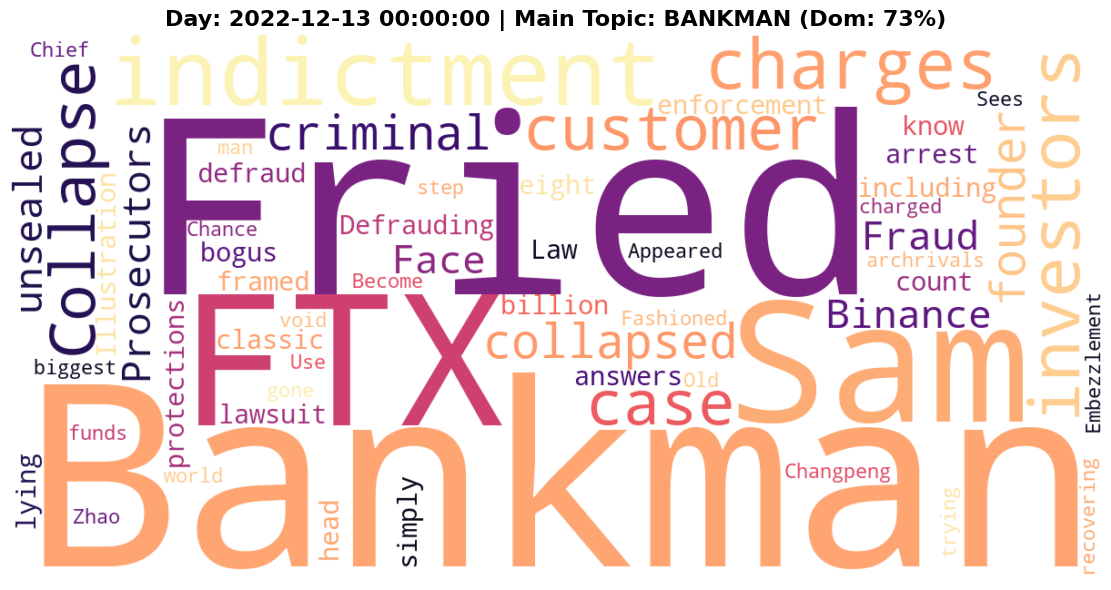



📅 DATE: 2018-06-28 00:00:00 | 📚 TOTAL: 13 Articles
🔑 MAIN TOPIC: 'BLOCKCHAIN'
📊 DOMINANCE SCORE: 46.2% (6/13 articles) -> MEDIUM Focus


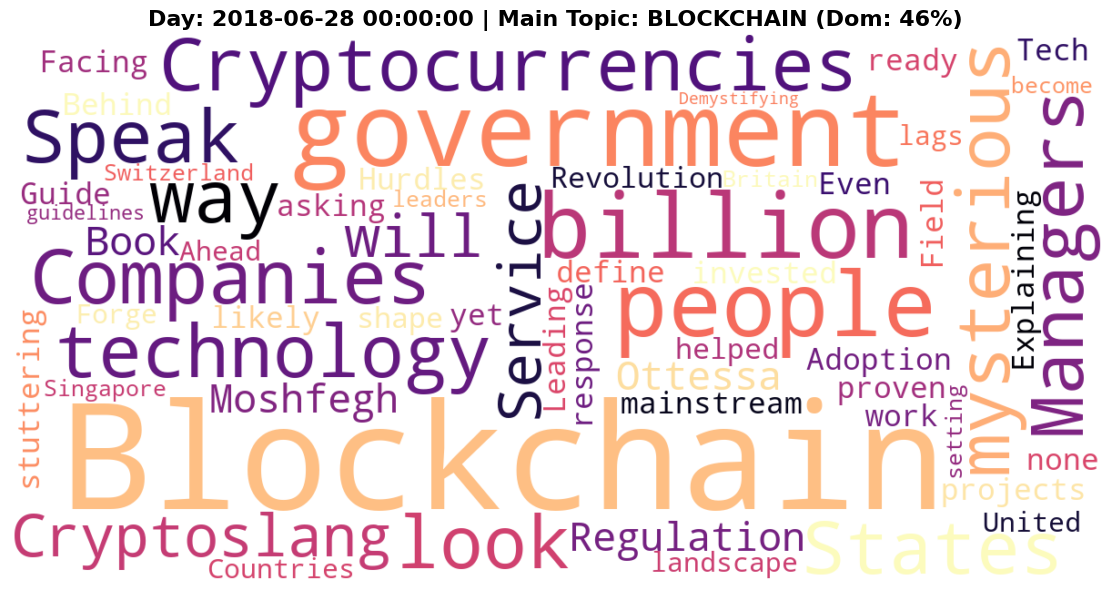



📅 DATE: 2022-11-30 00:00:00 | 📚 TOTAL: 13 Articles
🔑 MAIN TOPIC: 'FTX'
📊 DOMINANCE SCORE: 53.8% (7/13 articles) -> MEDIUM Focus


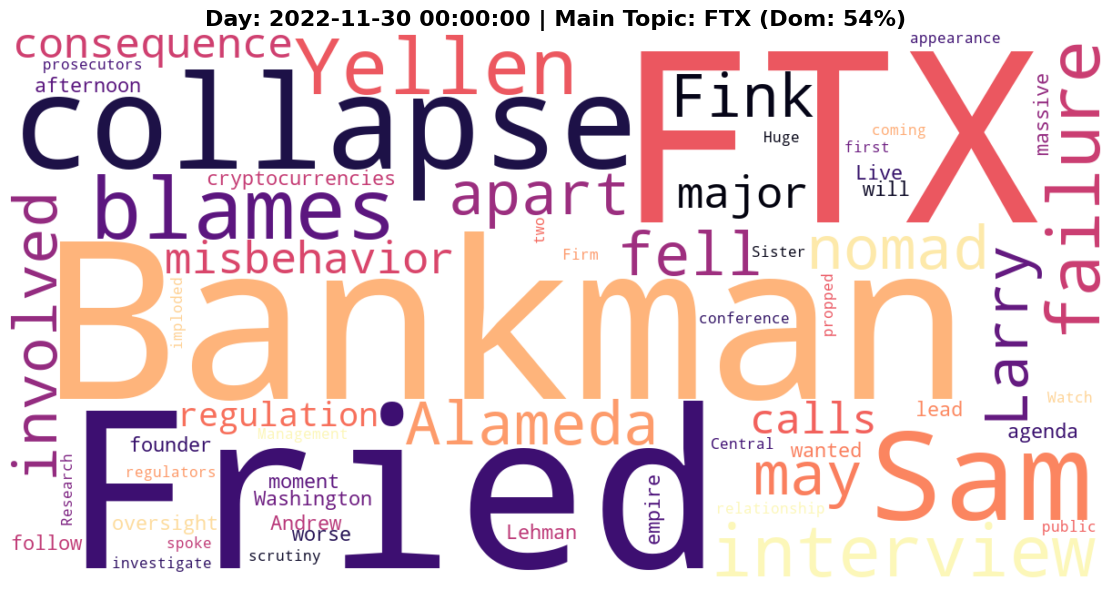

In [ ]:
data = db["daily_market_summary"].find()

# --- 1. CONFIGURATION: STOPWORDS ---
# Aggressive stopword list to remove journalism noise and generic crypto terms
custom_stopwords_b = set(STOPWORDS)
custom_stopwords_b.update([
    # Journalism / NYT Noise
    "new", "york", "times", "briefing", "daily", "today", "week", "year", "month",
    "mr", "ms", "mrs", "said", "say", "says", "reporting", "source", "according",
    "editor", "image", "photo", "credit", "getty", "images", "written", "morning",
    "evening", "posted", "updated", "associated", "press", "dealbook", "newsletter",
    "s", "c", "e", "a",
    
    # Generic Crypto/Finance Terms (allowing specific events to shine)
    "bitcoin", "crypto", "cryptocurrency", "digital", "currency", "market", 
    "price", "value", "investor", "money", "asset", "industry", "company",
    "trading", "exchange" 
])

# Stopwords for Metric Calculation
metric_stopwords = list(ENGLISH_STOP_WORDS) + list(custom_stopwords_b)

# --- 2. DATA PROCESSING ---
# Group articles by Date (Re-running this to ensure independence of the block)
days_map = {}
for doc in data:
    date_str = doc.get('date')
    articles = doc.get('articles', [])
    if date_str and articles:
        if date_str not in days_map: days_map[date_str] = []
        days_map[date_str].extend(articles)

# Find Top 3 Days by Volume
all_days = [{'date': k, 'articles': v, 'count': len(v)} for k, v in days_map.items()]
top_days = sorted(all_days, key=lambda x: x['count'], reverse=True)[:3]

print(f"Analyzing Top 3 Days: {[d['date'] for d in top_days]}\n")

# --- 3. ANALYSIS LOOP ---

for day_data in top_days:
    date_str = day_data['date']
    total_articles = day_data['count']
    articles = day_data['articles']
    
    # Prepare text for analysis
    abstracts = []       # For the Metric (Dominance)
    full_text_blob = ""  # For the WordCloud
    
    for art in articles:
        t = art.get('title', '') or ""
        a = art.get('abstract', '') or ""
        
        # Combine Title + Abstract
        text_clean = f"{t}. {a}".strip()
        
        full_text_blob += " " + text_clean
        abstracts.append(text_clean.lower())

    print("="*60)
    print(f"DATE: {date_str} | TOTAL: {total_articles} Articles")

    # --- A. METRIC: TOPIC DOMINANCE ---
    # Identify the most frequent keyword (Unigram or Bigram) and check coverage
    dominance_score = 0.0
    main_topic = "N/A"
    
    if total_articles > 0:
        try:
            # Look for top Unigrams (1 word) and Bigrams (2 words)
            vectorizer = CountVectorizer(
                stop_words=metric_stopwords, 
                ngram_range=(1, 2), 
                max_features=10
            )
            X = vectorizer.fit_transform(abstracts)
            
            # Sum counts to find the most frequent term
            sum_words = X.sum(axis=0) 
            words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            
            if words_freq:
                main_topic = words_freq[0][0].upper()
                
                # Count articles containing this topic
                count_topic = sum(1 for text in abstracts if main_topic.lower() in text)
                dominance_score = count_topic / total_articles
                
                # Interpret Score
                rating = "LOW Focus"
                if dominance_score > 0.4: rating = "MEDIUM Focus"
                if dominance_score > 0.65: rating = "HIGH DOMINANCE (Breaking News)"
                
                print(f"MAIN TOPIC: '{main_topic}'")
                print(f"DOMINANCE SCORE: {dominance_score:.1%} ({count_topic}/{total_articles} articles) -> {rating}")
        except ValueError:
            print("Not enough text for metric analysis.")

    # --- B. VISUALIZATION: WORDCLOUD ---
    if full_text_blob.strip():
        plt.figure(figsize=(12, 6))
        
        wc = WordCloud(
            width=1200, 
            height=600, 
            background_color='white', 
            stopwords=custom_stopwords_b, 
            colormap='magma', 
            max_words=60, 
            collocations=False # Avoid repeating phrases like "Sam Bankman" vs "Bankman"
        ).generate(full_text_blob)
        
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f"Day: {date_str} | Main Topic: {main_topic} (Dom: {dominance_score:.0%})", fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough text for WordCloud.")
    
    print("\n")

YEAR       | TOTAL ARTICLES  | DAYS IN DB     
---------------------------------------------
2018       | 336             | 365            
2019       | 112             | 365            
2020       | 107             | 366            
2021       | 579             | 365            
2022       | 806             | 365            
2023       | 547             | 365            
2024       | 473             | 366            
2025       | 698             | 345            


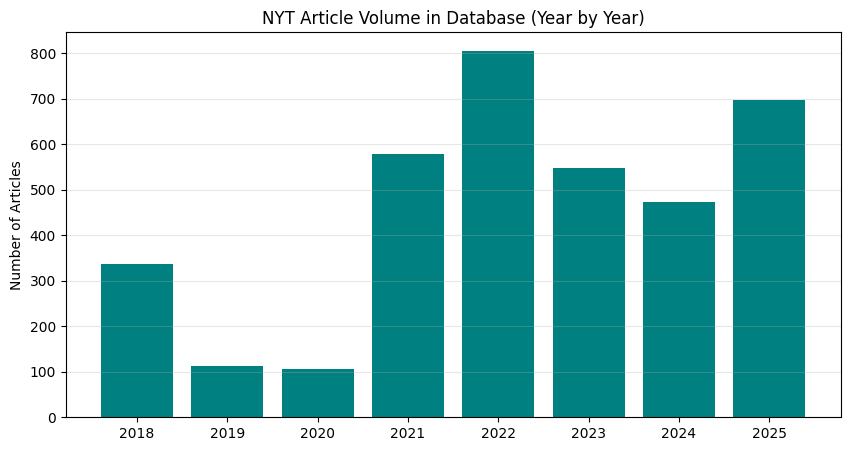

In [8]:
# Aggregation: Count articles per Year
pipeline_yearly = [
    {
        "$project": {
            "year": {"$substr": ["$date_str", 0, 4]}, # Extract YYYY from date string
            "article_count": {"$size": "$articles"}   # Count size of articles array
        }
    },
    {
        "$group": {
            "_id": "$year",
            "total_articles": {"$sum": "$article_count"}, # Sum of article counts
            "days_with_news": {"$sum": 1}                 # Count of days with entries
        }
    },
    {"$sort": {"_id": 1}} # Sort chronological (2018 -> 2024)
]

results = list(collection.aggregate(pipeline_yearly))

# Print Table
print(f"{'YEAR':<10} | {'TOTAL ARTICLES':<15} | {'DAYS IN DB':<15}")
print("-" * 45)
for r in results:
    print(f"{r['_id']:<10} | {r['total_articles']:<15} | {r['days_with_news']:<15}")

# Plot Histogram
years = [r['_id'] for r in results]
counts = [r['total_articles'] for r in results]

plt.figure(figsize=(10, 5))
plt.bar(years, counts, color='teal')
plt.title("NYT Article Volume in Database (Year by Year)")
plt.ylabel("Number of Articles")
plt.grid(axis='y', alpha=0.3)
plt.show()

#### Wordcloud + sentiment:

Loading FinBERT model...


Device set to use cpu


Configuring Text Cleaner (NLTK)...
Found 2902 days. Starting deep analysis...


Global Analysis: 100%|██████████| 2902/2902 [03:26<00:00, 14.06it/s]



Analyzed 3658 articles.
Counts: {'positive': 261, 'neutral': 2251, 'negative': 1146}
Cleaning text for visualization...


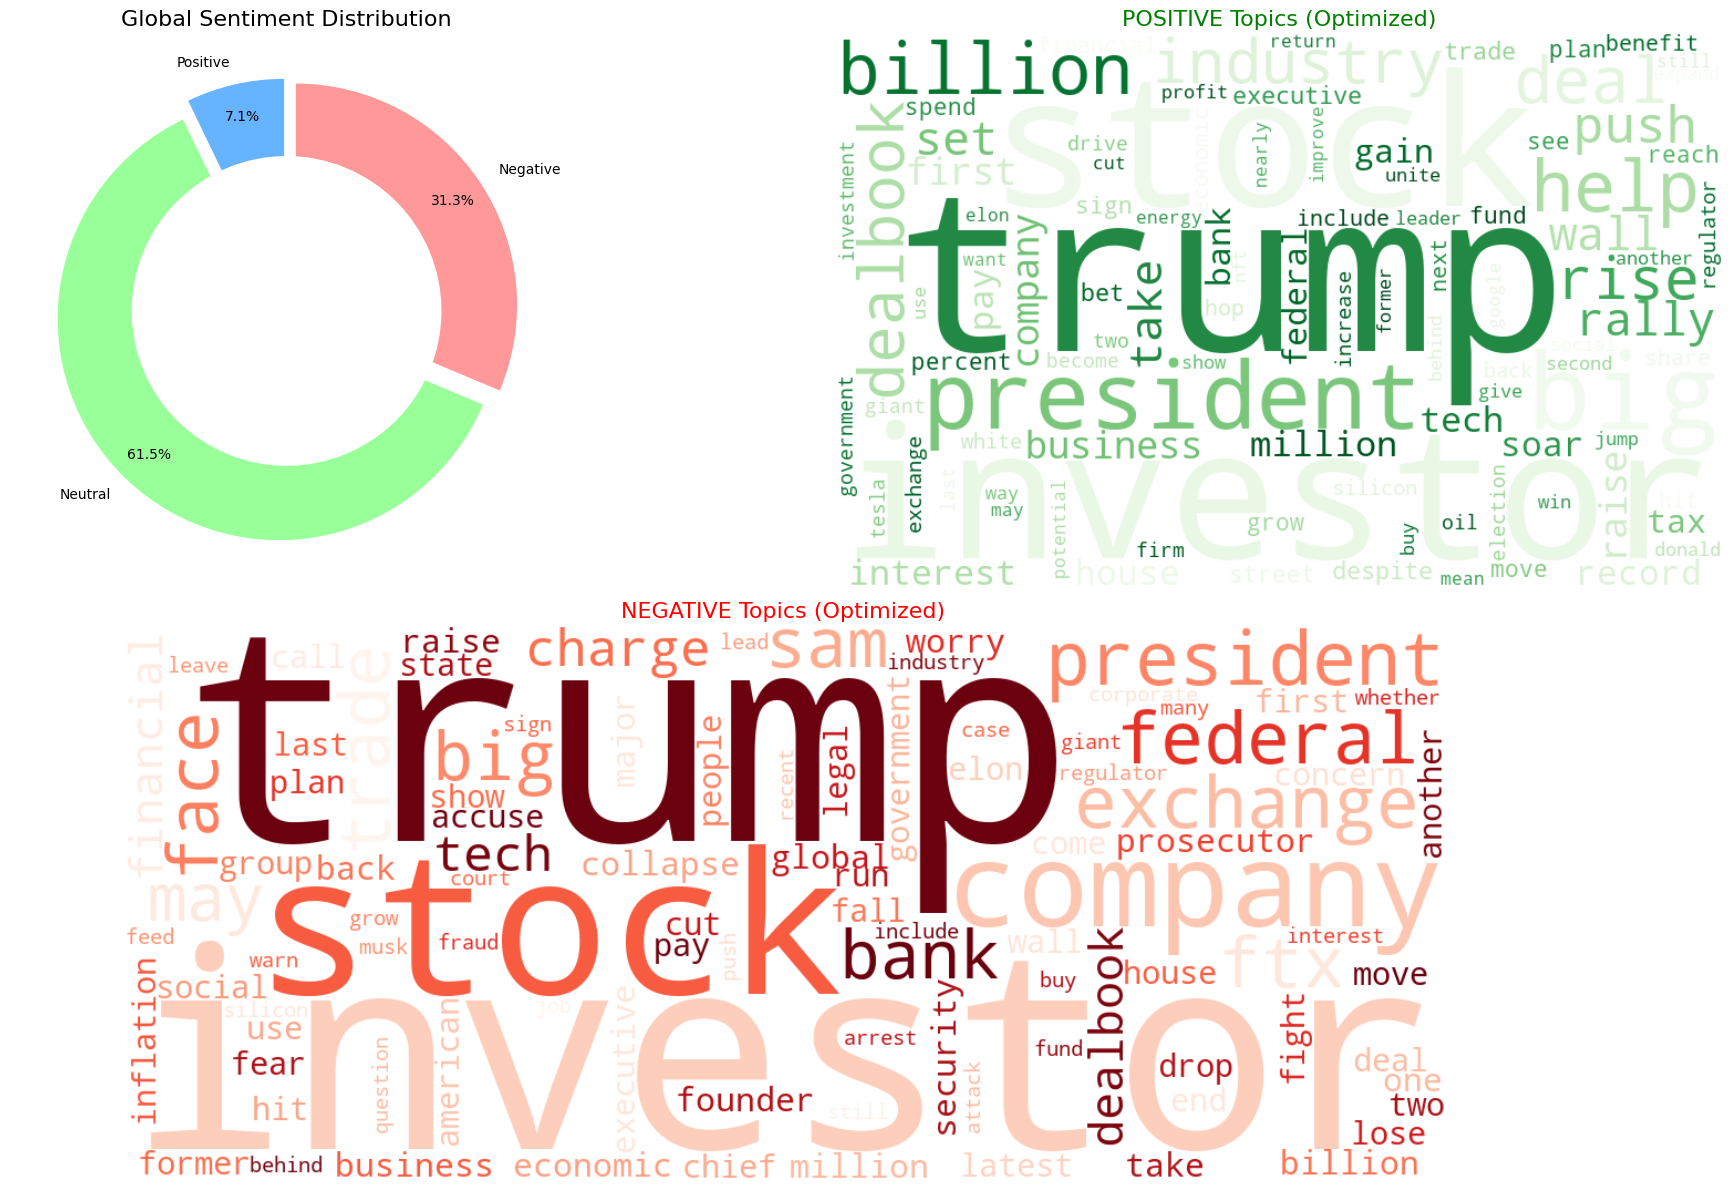

In [15]:
# --- 1. SETUP & MODEL LOADING ---
print("Loading FinBERT model...")
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
device = 0 if torch.cuda.is_available() else -1 
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

# --- 2. SETUP NLTK CLEANER ---
print("Configuring Text Cleaner (NLTK)...")

# Download resources (run once)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)

lemmatizer = WordNetLemmatizer()

# Define Custom Stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords.words('english'))
custom_stopwords.update([
    "said", "say", "says", "reported", "according", "mr", "ms", "mrs", 
    "editor", "opinion", "page", "section", "news", "report", "writer",
    "briefing", "evening", "morning", "daily", "week", "year", "month",
    "today", "yesterday", "time", "day", "new", "york", "times",
    "bitcoin", "crypto", "cryptocurrency", "currency", "digital", 
    "market", "price", "money", "value", "coin", "token",
    "going", "make", "made", "would", "could", "also", "even"
])

def clean_and_lemmatize(text):
    if not text: return ""
    try:
        tokens = word_tokenize(text.lower())
    except LookupError:
        tokens = text.lower().split()
        
    cleaned_tokens = []
    for word in tokens:
        if word.isalpha() and len(word) > 2 and word not in custom_stopwords:
            try:
                lemma = lemmatizer.lemmatize(word, pos='v') # Verb
                lemma = lemmatizer.lemmatize(lemma, pos='n') # Noun
                if lemma not in custom_stopwords:
                    cleaned_tokens.append(lemma)
            except:
                cleaned_tokens.append(word)
    return " ".join(cleaned_tokens)

# --- 3. DATA EXTRACTION & ANALYSIS ---
print("Downloading all documents...")
cursor = collection.find({})
all_docs = list(cursor)

sentiment_counts = {'positive': 0, 'neutral': 0, 'negative': 0}
text_positive = ""
text_negative = ""
total_articles = 0

print(f"Found {len(all_docs)} days. Starting deep analysis...")

for doc in tqdm(all_docs, desc="Global Analysis"):
    articles = doc.get('articles', [])
    
    for art in articles:
        t = art.get('title', '') or ""
        a = art.get('abstract', '') or ""
        full_text = f"{t}. {a}".strip()
        
        if len(full_text) > 10:
            total_articles += 1
            
            try:
                # FinBERT Analysis
                res = nlp(full_text[:512])[0]
                label = res['label']
                sentiment_counts[label] += 1
                
                # Accumulate text based on sentiment
                if label == 'positive':
                    text_positive += " " + full_text
                elif label == 'negative':
                    text_negative += " " + full_text
                    
            except Exception:
                pass

print(f"\nAnalyzed {total_articles} articles.")
print(f"Counts: {sentiment_counts}")

# --- 4. VISUALIZATION ---
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2)

# A. PIE CHART (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
labels = ['Positive', 'Neutral', 'Negative']
sizes = [sentiment_counts['positive'], sentiment_counts['neutral'], sentiment_counts['negative']]
colors = ['#66b3ff', '#99ff99', '#ff9999']
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, pctdistance=0.85, explode=(0.05, 0.05, 0.05))
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax1.set_title('Global Sentiment Distribution', fontsize=16)

# B. CLEANING TEXT FOR WORDCLOUDS
print("Cleaning text for visualization...")
clean_pos = clean_and_lemmatize(text_positive)
clean_neg = clean_and_lemmatize(text_negative)

# C. POSITIVE WORDCLOUD (Top Right)
ax2 = fig.add_subplot(gs[0, 1])
if clean_pos:
    wc_pos = WordCloud(width=800, height=500, background_color='white', 
                       stopwords=custom_stopwords, colormap='Greens', 
                       max_words=100, collocations=False).generate(clean_pos)
    ax2.imshow(wc_pos, interpolation='bilinear')
    ax2.set_title("POSITIVE Topics (Optimized)", fontsize=16, color='green')
ax2.axis('off')

# D. NEGATIVE WORDCLOUD (Bottom Center)
ax3 = fig.add_subplot(gs[1, :]) # Spans both columns
if clean_neg:
    wc_neg = WordCloud(width=1200, height=500, background_color='white', 
                       stopwords=custom_stopwords, colormap='Reds', 
                       max_words=100, collocations=False).generate(clean_neg)
    ax3.imshow(wc_neg, interpolation='bilinear')
    ax3.set_title("NEGATIVE Topics (Optimized)", fontsize=16, color='red')
ax3.axis('off')

plt.tight_layout()
plt.show()

Reprocessing text to separate Positive vs Negative...


Splitting Sentiment: 100%|██████████| 2902/2902 [03:20<00:00, 14.46it/s]


Separation complete! (Positive: 261, Negative: 1146)
Lemmatizing Positive text...
Lemmatizing Negative text...


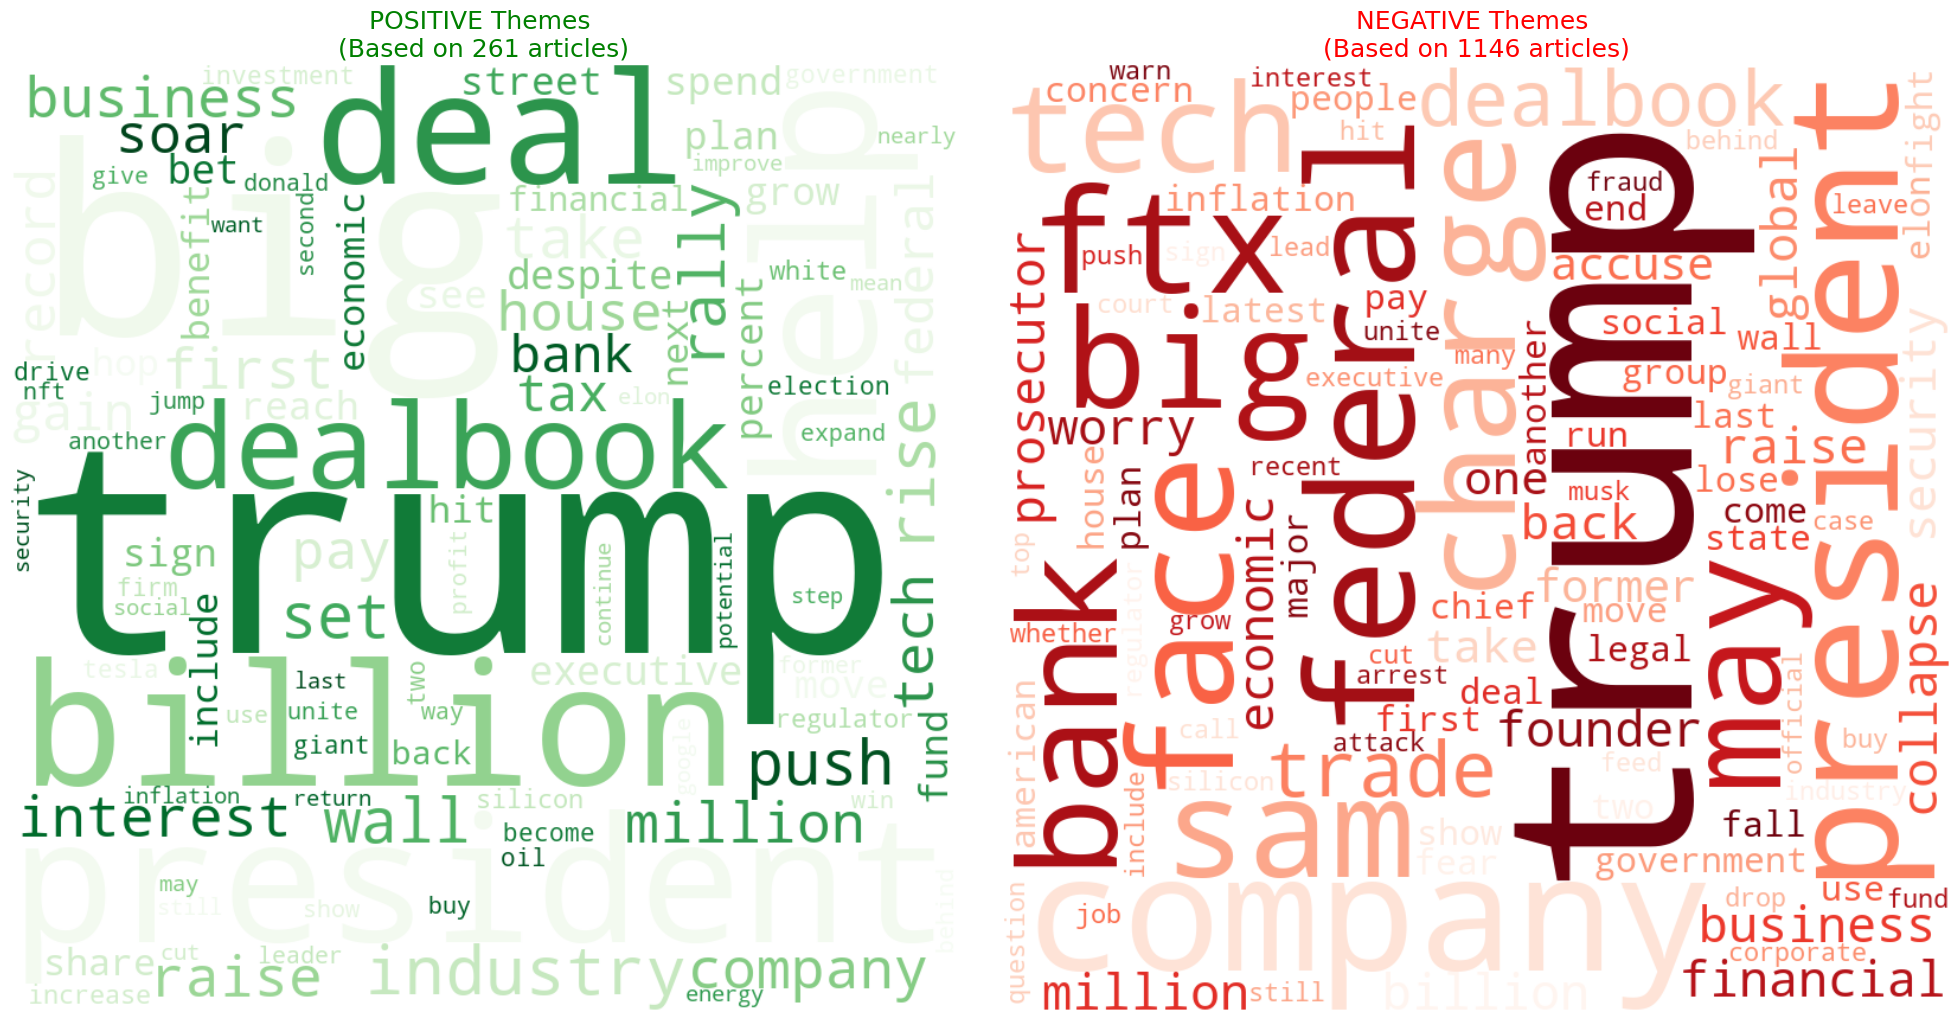

In [10]:
lemmatizer = WordNetLemmatizer()

# --- 2. DEFINE STOPWORDS (The "Blacklist" from the Second Snippet) ---
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(stopwords.words('english'))

# Journalistic Noise (NYT Style)
journalism_noise = [
    "said", "say", "says", "reported", "according", "mr", "ms", "mrs", 
    "editor", "opinion", "page", "section", "news", "report", "writer",
    "briefing", "evening", "morning", "daily", "week", "year", "month",
    "today", "yesterday", "time", "day", "new", "york", "times", "previous"
]

# Domain Noise (Crypto terms that are too generic)
domain_noise = [
    "bitcoin", "crypto", "cryptocurrency", "currency", "digital", 
    "market", "price", "money", "value", "coin", "token",
    "going", "make", "made", "would", "could", "also", "even",
    "investor", "trading", "stock", "exchange"
]

custom_stopwords.update(journalism_noise)
custom_stopwords.update(domain_noise)

# Cleaning Function (From the Second Snippet)
def clean_and_lemmatize(text):
    if not text: return ""
    try:
        tokens = word_tokenize(text.lower())
    except LookupError:
        tokens = text.lower().split()
    
    cleaned_tokens = []
    for word in tokens:
        # Filter: Only letters, length > 2 chars, not in stopwords
        if word.isalpha() and len(word) > 2 and word not in custom_stopwords:
            try:
                # Lemmatization: First Verbs, then Nouns
                lemma = lemmatizer.lemmatize(word, pos='v') 
                lemma = lemmatizer.lemmatize(lemma, pos='n') 
                
                if lemma not in custom_stopwords:
                    cleaned_tokens.append(lemma)
            except Exception:
                cleaned_tokens.append(word)
                
    return " ".join(cleaned_tokens)

# --- 3. TEXT SEPARATION (Logic from the First Snippet) ---
# We assume that 'all_docs' and 'nlp' are already defined from previous cells
print("Reprocessing text to separate Positive vs Negative...")

raw_text_positive = ""
raw_text_negative = ""
count_pos = 0
count_neg = 0

for doc in tqdm(all_docs, desc="Splitting Sentiment"):
    articles = doc.get('articles', [])
    for art in articles:
        t = art.get('title', '') or ""
        a = art.get('abstract', '') or ""
        full_text = f"{t}. {a}".strip()
        
        if len(full_text) > 10:
            try:
                # Re-run inference to ensure category accuracy
                res = nlp(full_text[:512])[0]
                label = res['label']
                
                if label == 'positive':
                    raw_text_positive += " " + full_text
                    count_pos += 1
                elif label == 'negative':
                    raw_text_negative += " " + full_text
                    count_neg += 1
            except Exception:
                pass

print(f"Separation complete! (Positive: {count_pos}, Negative: {count_neg})")

# --- 4. APPLYING CLEANING (Logic from the Second Snippet) ---
print("Lemmatizing Positive text...")
clean_pos_text = clean_and_lemmatize(raw_text_positive)

print("Lemmatizing Negative text...")
clean_neg_text = clean_and_lemmatize(raw_text_negative)

# --- 5. VISUALIZATION ---
if not clean_pos_text and not clean_neg_text:
    print("No valid text found for visualization.")
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # A. POSITIVE WordCloud (Green)
    if clean_pos_text:
        wc_pos = WordCloud(
            width=800, height=800, 
            background_color='white', 
            stopwords=custom_stopwords, 
            colormap='Greens',  
            max_words=100,
            collocations=False
        ).generate(clean_pos_text)
        
        ax1.imshow(wc_pos, interpolation='bilinear')
        ax1.set_title(f"POSITIVE Themes \n(Based on {count_pos} articles)", fontsize=18, color='green')
    ax1.axis('off')

    # B. NEGATIVE WordCloud (Red)
    if clean_neg_text:
        wc_neg = WordCloud(
            width=800, height=800, 
            background_color='white', 
            stopwords=custom_stopwords,
            colormap='Reds',    
            max_words=100,
            collocations=False
        ).generate(clean_neg_text)
        
        ax2.imshow(wc_neg, interpolation='bilinear')
        ax2.set_title(f"NEGATIVE Themes \n(Based on {count_neg} articles)", fontsize=18, color='red')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()


>>> RUNNING CRISIS SCENARIOS

--- ANALYZING PERIOD: 1. COVID Crash  (2020-03-01 - 2020-03-31) ---
Found 31 days. Processing articles...


Processing: 100%|██████████| 31/31 [00:00<00:00, 55.32it/s]


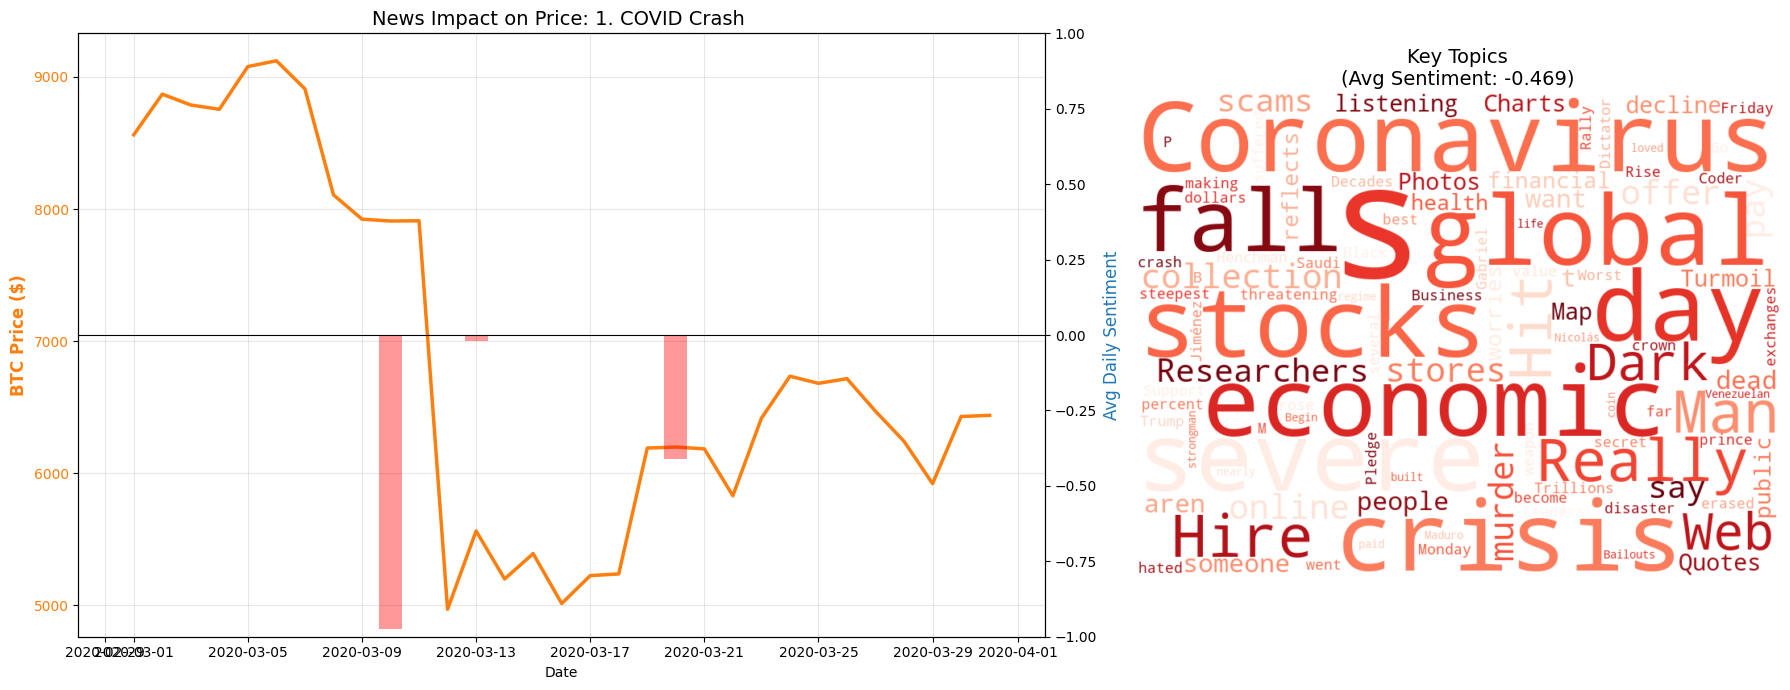


--- ANALYZING PERIOD: 2. China Ban & Musk 🇨🇳 (2021-05-01 - 2021-05-31) ---
Found 31 days. Processing articles...


Processing: 100%|██████████| 31/31 [00:03<00:00,  7.94it/s]


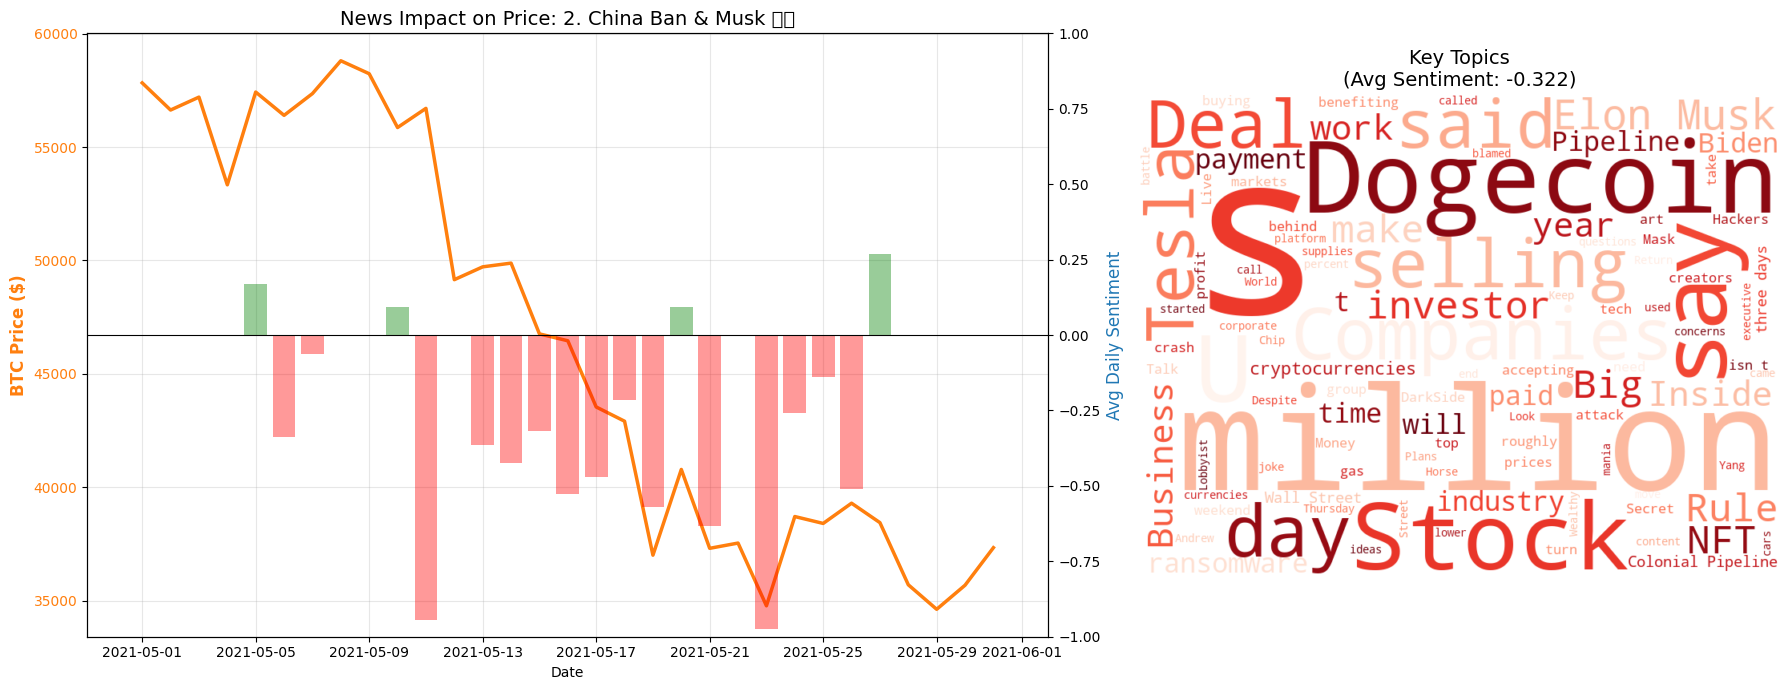


--- ANALYZING PERIOD: 3. FTX Collapse  (2022-11-01 - 2022-11-30) ---
Found 30 days. Processing articles...


Processing: 100%|██████████| 30/30 [00:05<00:00,  5.15it/s]


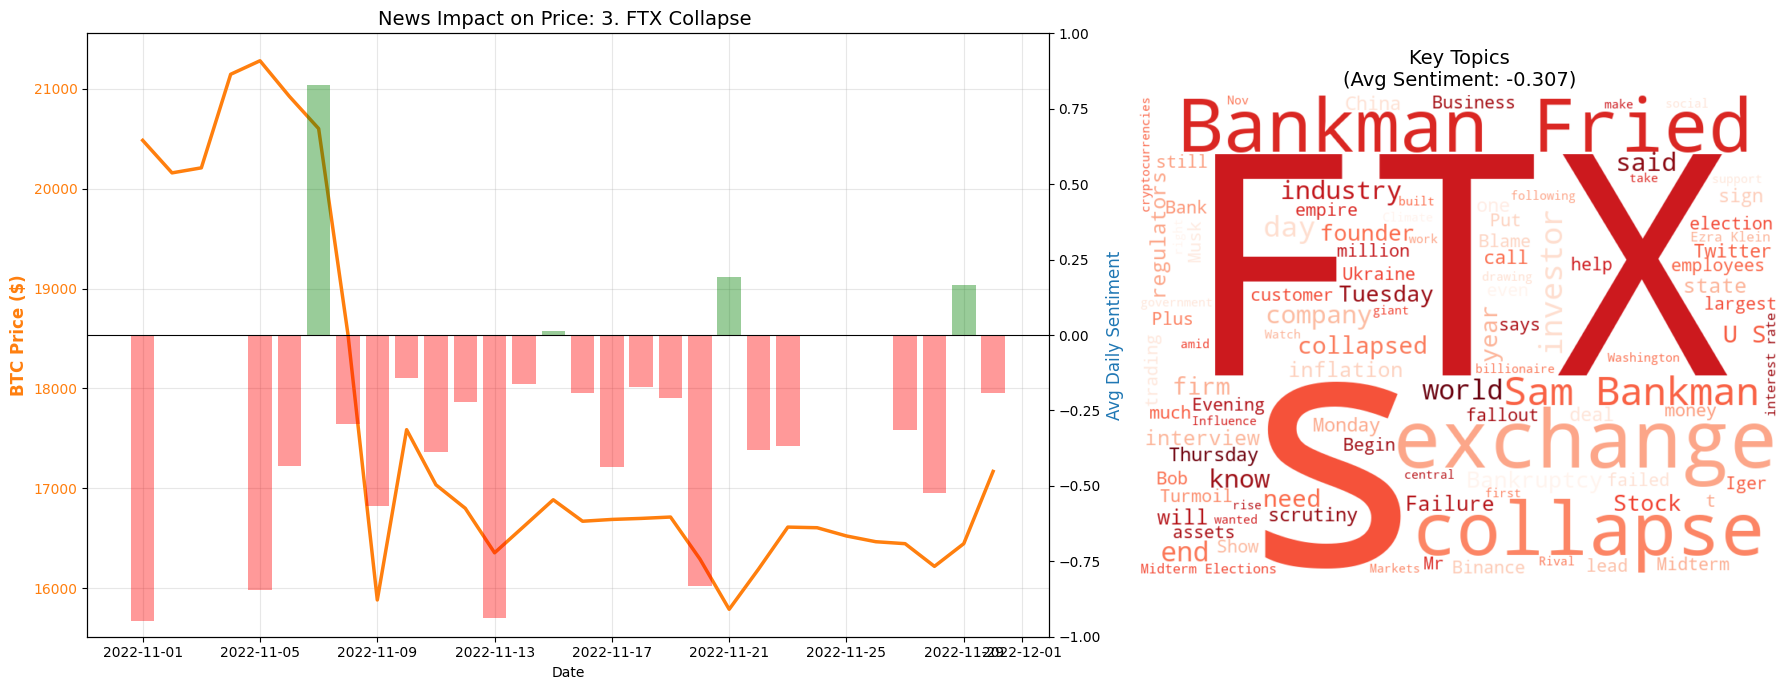


>>> RUNNING GROWTH SCENARIOS

--- ANALYZING PERIOD: 1. PayPal Adoption  (2020-10-01 - 2020-12-31) ---
Found 92 days. Processing articles...


Processing: 100%|██████████| 92/92 [00:01<00:00, 51.12it/s]


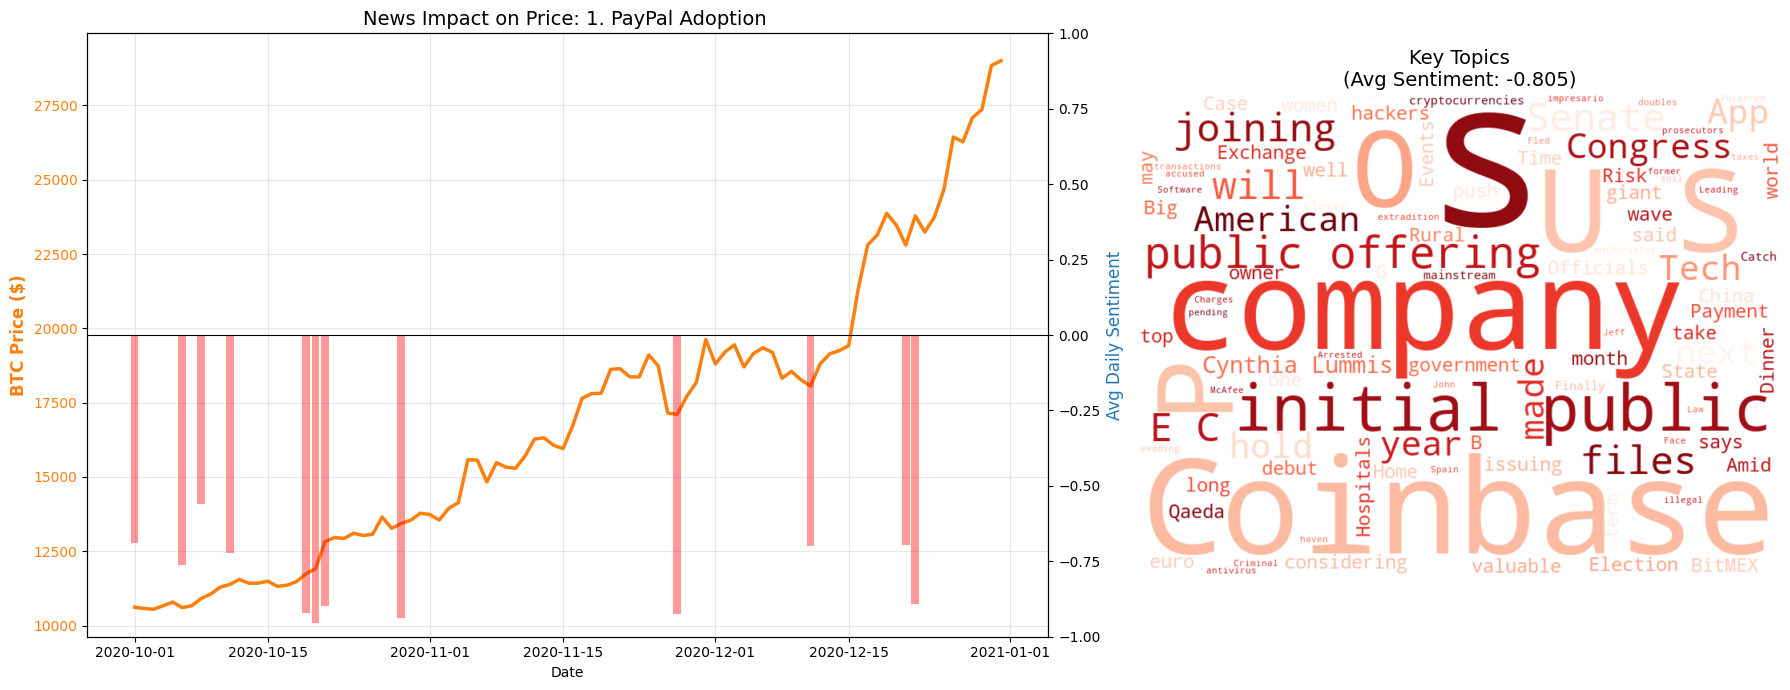


--- ANALYZING PERIOD: 2. Inflation Hedge  (2021-10-01 - 2021-11-15) ---
Found 46 days. Processing articles...


Processing: 100%|██████████| 46/46 [00:02<00:00, 15.79it/s]


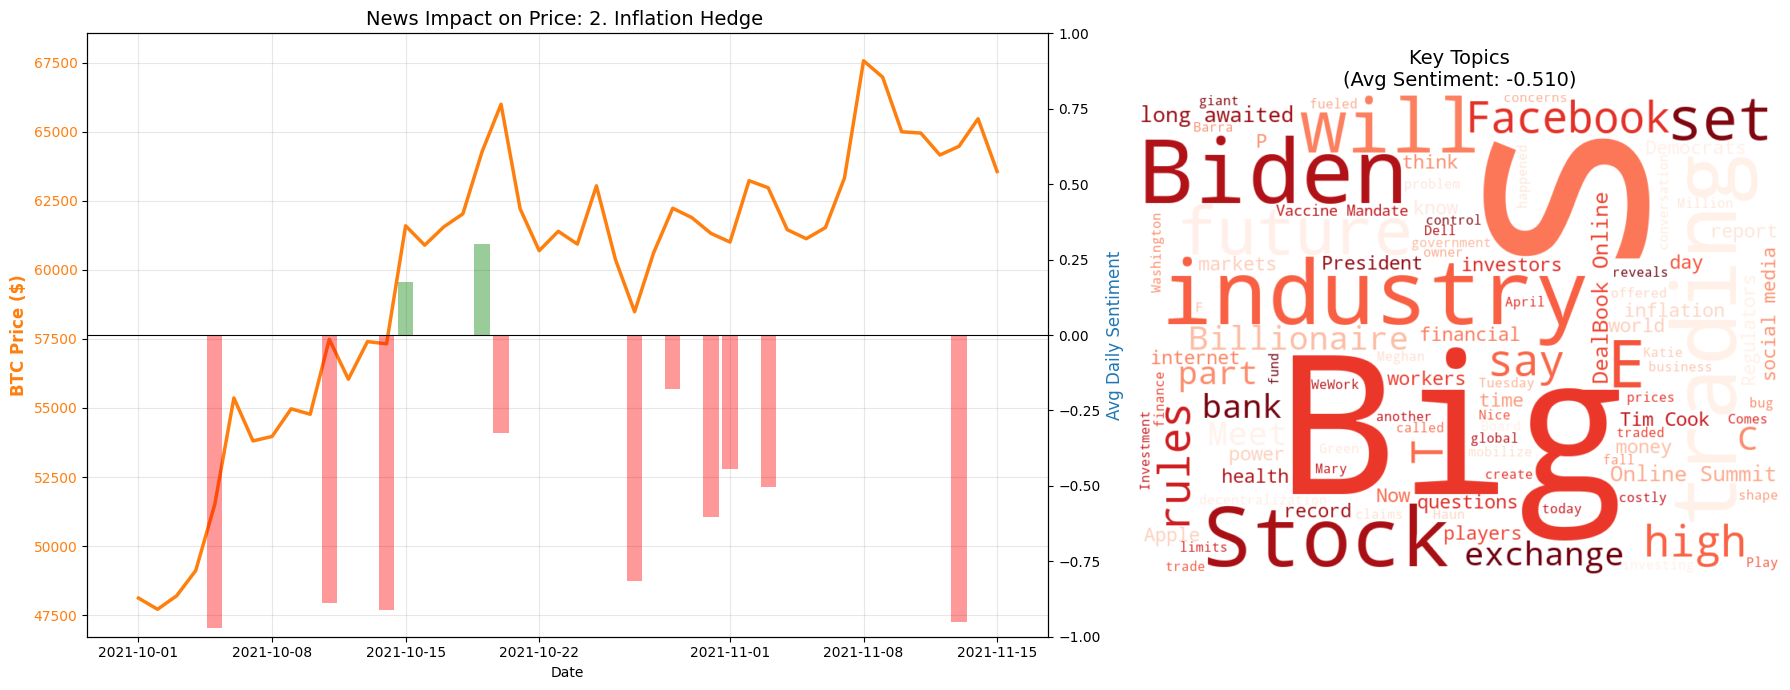


--- ANALYZING PERIOD: 3. ETF Approval  (2024-01-01 - 2024-01-31) ---
Found 31 days. Processing articles...


Processing: 100%|██████████| 31/31 [00:01<00:00, 15.86it/s]


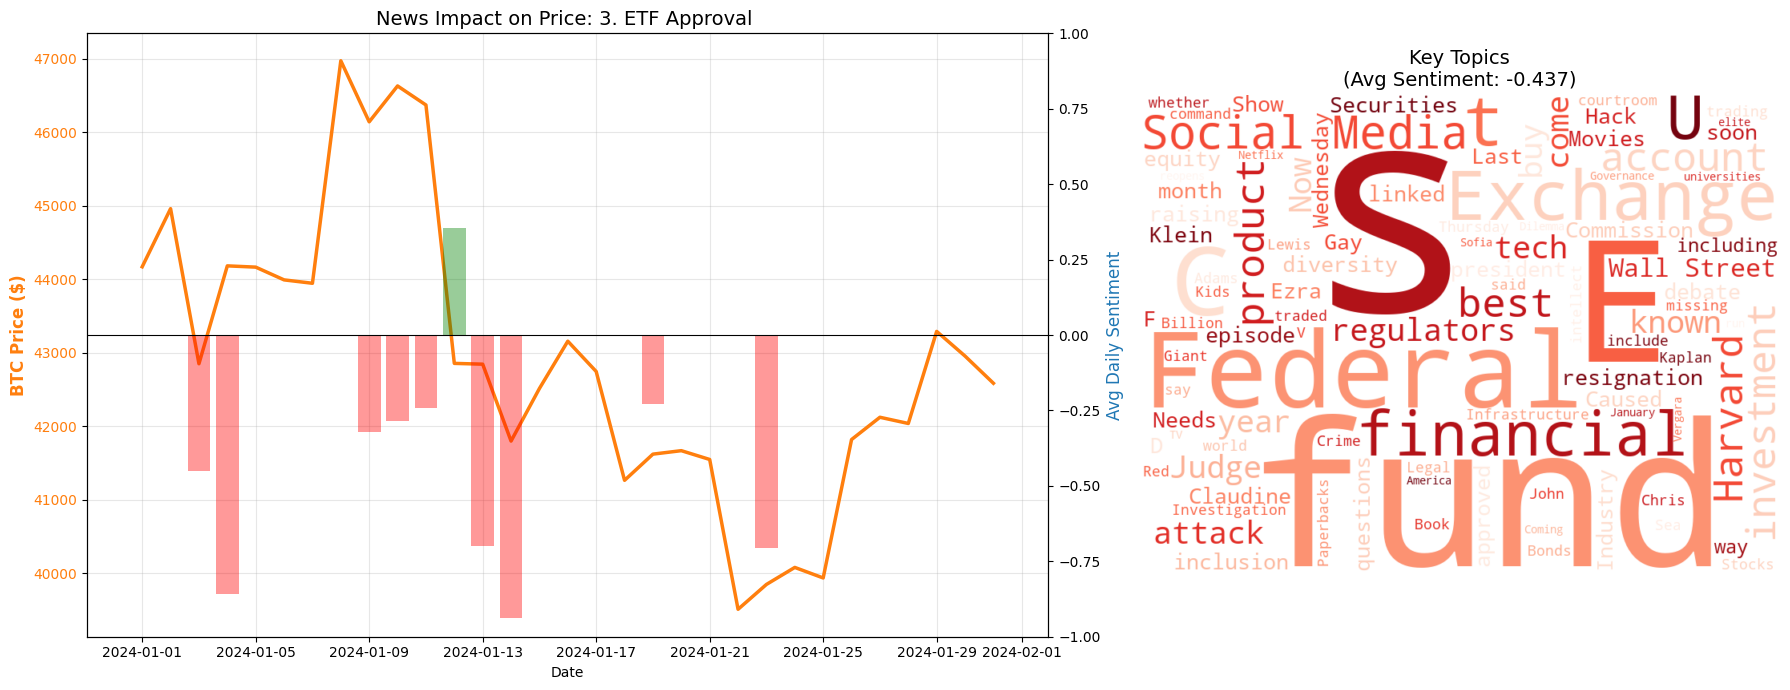

In [11]:
# --- 1. ANALYSIS FUNCTION ---
def analyze_mongo_period(start_date, end_date, event_title):
    print(f"\n--- ANALYZING PERIOD: {event_title} ({start_date} - {end_date}) ---")
    
    # Query documents within date range
    query = {
        "date_str": {
            "$gte": start_date,
            "$lte": end_date
        }
    }
    cursor = collection.find(query).sort("date_str", 1)
    days_found = list(cursor)
    
    if not days_found:
        print("No data found in this time range.")
        return

    print(f"Found {len(days_found)} days. Processing articles...")

    # Data Containers
    dates_plot = []
    prices_plot = []
    sentiments_plot = []
    all_text_for_cloud = ""
    total_articles_processed = 0

    for doc in tqdm(days_found, desc="Processing"):
        # Extract Price
        date_val = doc.get('date_str')
        try:
            close_price = doc['prices']['BTC-USD']['close']
        except (KeyError, TypeError):
            close_price = None
        
        # Extract & Analyze Articles
        articles = doc.get('articles', [])
        daily_scores = []
        
        for art in articles:
            t = art.get('title', '') or ""
            a = art.get('abstract', '') or ""
            full_text = f"{t}. {a}".strip()
            
            if len(full_text) > 10:
                all_text_for_cloud += " " + full_text
                try:
                    res = nlp(full_text[:512])[0]
                    score = res['score']
                    label = res['label']
                    
                    # Map to numeric score (-1 to 1)
                    val = -score if label == 'negative' else (0 if label == 'neutral' else score)
                    daily_scores.append(val)
                    total_articles_processed += 1
                except:
                    pass

        # Daily Aggregation
        dates_plot.append(pd.to_datetime(date_val))
        prices_plot.append(close_price)
        sentiments_plot.append(np.mean(daily_scores) if daily_scores else 0)

    if total_articles_processed == 0:
        print("No valid articles found for text analysis.")
        return

    avg_period_sentiment = np.mean([s for s in sentiments_plot if s != 0]) if any(s != 0 for s in sentiments_plot) else 0
    
    # --- VISUALIZATION (Dashboard) ---
    fig = plt.figure(figsize=(18, 7))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])

    # Plot A: Price vs Sentiment
    ax1 = fig.add_subplot(gs[0])
    color_price = 'tab:orange'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('BTC Price ($)', color=color_price, fontsize=12, fontweight='bold')
    ax1.plot(dates_plot, prices_plot, color=color_price, linewidth=2.5, label='BTC Price')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f"News Impact on Price: {event_title}", fontsize=14)

    # Twin axis for Sentiment Bars
    ax2 = ax1.twinx()
    bar_colors = ['green' if s > 0 else 'red' for s in sentiments_plot]
    ax2.bar(dates_plot, sentiments_plot, alpha=0.4, color=bar_colors, width=0.8, label='Daily Sentiment')
    ax2.set_ylabel('Avg Daily Sentiment', color='tab:blue', fontsize=12)
    ax2.set_ylim(-1, 1)
    ax2.axhline(0, color='black', linewidth=0.8)

    # Plot B: WordCloud
    ax3 = fig.add_subplot(gs[1])
    my_stopwords = set(STOPWORDS)
    my_stopwords.update(["Bitcoin", "Crypto", "Cryptocurrency", "Currency", "Digital", "Price", "Market", "New", "York", "Times", "Briefing", "Week"])
    
    cmap = 'Reds' if avg_period_sentiment < 0 else 'viridis'
    wc = WordCloud(width=800, height=600, background_color='white', 
                   stopwords=my_stopwords, colormap=cmap, max_words=100).generate(all_text_for_cloud)
    
    ax3.imshow(wc, interpolation='bilinear')
    ax3.axis('off')
    ax3.set_title(f"Key Topics\n(Avg Sentiment: {avg_period_sentiment:.3f})", fontsize=14)

    plt.tight_layout()
    plt.show()

# --- 2. DEFINE PERIODS & RUN ---

# Set 1: Critical/Crisis Periods
crisis_periods = [
    ("1. COVID Crash ",       "2020-03-01", "2020-03-31"),
    ("2. China Ban & Musk 🇨🇳", "2021-05-01", "2021-05-31"),
    ("3. FTX Collapse ",      "2022-11-01", "2022-11-30"),
]

# Set 2: Growth/Adoption Periods
growth_periods = [
    ("1. PayPal Adoption ",   "2020-10-01", "2020-12-31"),
    ("2. Inflation Hedge ",   "2021-10-01", "2021-11-15"),
    ("3. ETF Approval ",      "2024-01-01", "2024-01-31")
]

# Choose which list to run (or run both)
print("\n>>> RUNNING CRISIS SCENARIOS")
for title, start, end in crisis_periods:
    analyze_mongo_period(start, end, title)

print("\n>>> RUNNING GROWTH SCENARIOS")
for title, start, end in growth_periods:
    analyze_mongo_period(start, end, title)

🔌 Filtering articles by topic...
TOPIC: PRESIDENT TRUMP
Articles found: 611
------------------------------------------------------------
5 Representative Examples:
   1. Trump’s Xenophobic Outburst, and a Planned Donation to 25 Million U.S. Kids. Plus, the 10 best books of the year....
   2. Trump Begins Selling New Crypto Token, Raising Ethical Concerns. The president-elect and his family have a direct and potentially lucrative stake in t...
   3. The Secret Deals Behind Trump’s Crypto Firm, and a Revenge Porn Ban. Plus, let’s hear your best sea gull....
   4. America’s Energy Needs and Climate Goals. Responses to a front-page article. Also: The bridge collapse; Donald Trump and the $60 Bible; political qual...
   5. Trevor Noah Is Skeptical About Trump’s Health Report. The White House physician on Tuesday said President Trump was in excellent health, physically an...


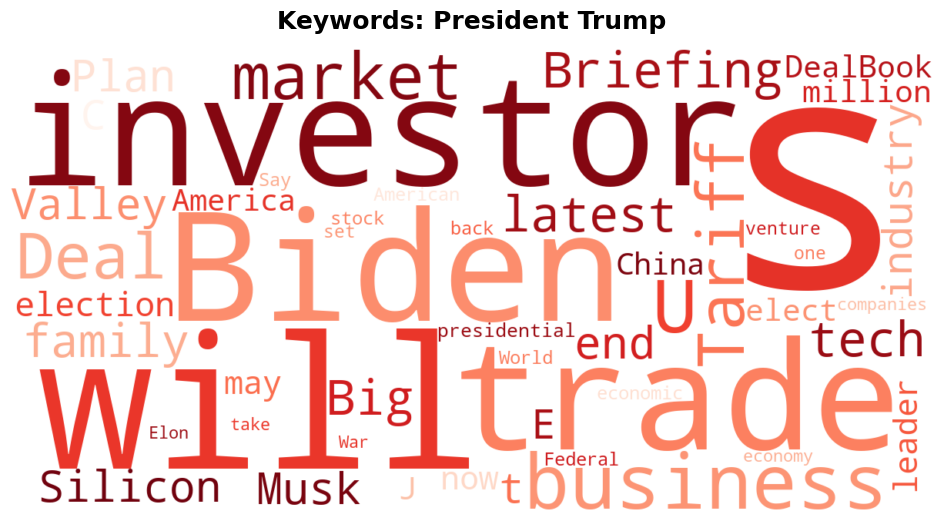




TOPIC: ELON MUSK
Articles found: 458
------------------------------------------------------------
5 Representative Examples:
   1. Debt Has Entered the A.I. Boom. To fund heavy spending on infrastructure for artificial intelligence, companies have leveraged a growing list of compl...
   2. Elon’s Two-Day War with Apple + How to Beat an A.I. Censor + S.B.F.’s ‘Bad Month’. Musk takes on tech’s fight against the Apple “tax.”...
   3. Scammers Stole Their Savings, and Then the Tax Bill Arrived. The victims pulled money out of their retirement accounts. The withdrawals had inflated t...
   4. The Fallout From Musk’s Profanity-Laden Attack on Advertisers Isn’t Over. Shares in Tesla fell despite the release of the Cybertruck pickup on Thursda...
   5. Musk vs. the Bots. Plus, latest crypto crash causes regulators to push for new investor protections....


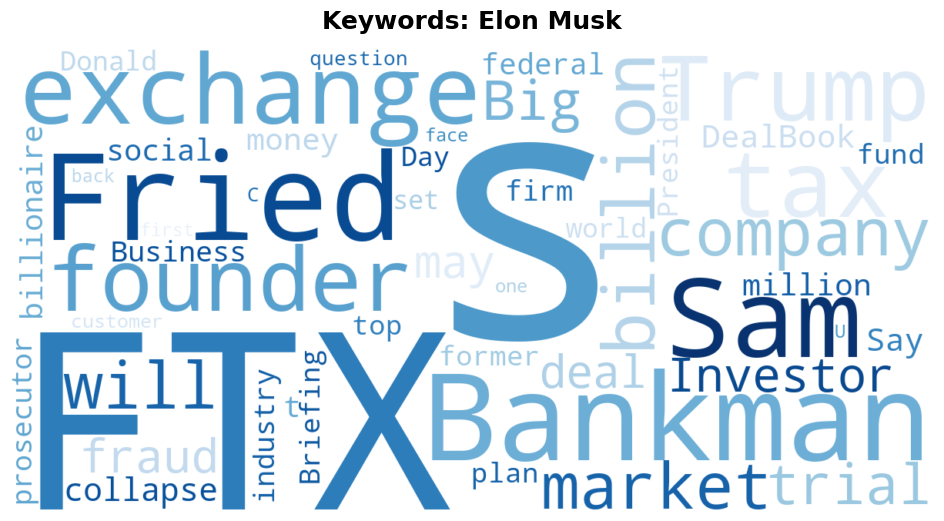




TOPIC: FRAUD & SCANDALS
Articles found: 389
------------------------------------------------------------
5 Representative Examples:
   1. The Crypto Comeback. The fate of Sam Bankman-Fried’s FTX, and what it says about the improbable resurgence of cryptocurrencies....
   2. Drugs, Scams and Sin: Myanmar’s War Has Made It the Global Crime Capital. The chaotic country is now a magnet for criminal syndicates, particularly fr...
   3. Treasury Dept. blacklists crypto platform used in money laundering.. The crackdown was the government’s latest effort to rein in the crypto industry....
   4. Phony Romeos? Email Threats? Dissecting the Anatomy of an Online Scam.. In a series for the Business desk, a reporter is chasing down sophisticated on...
   5. Treasury to Roll Out Cryptocurrency Rules. The rules will improve transparency in hopes of stopping money laundering....


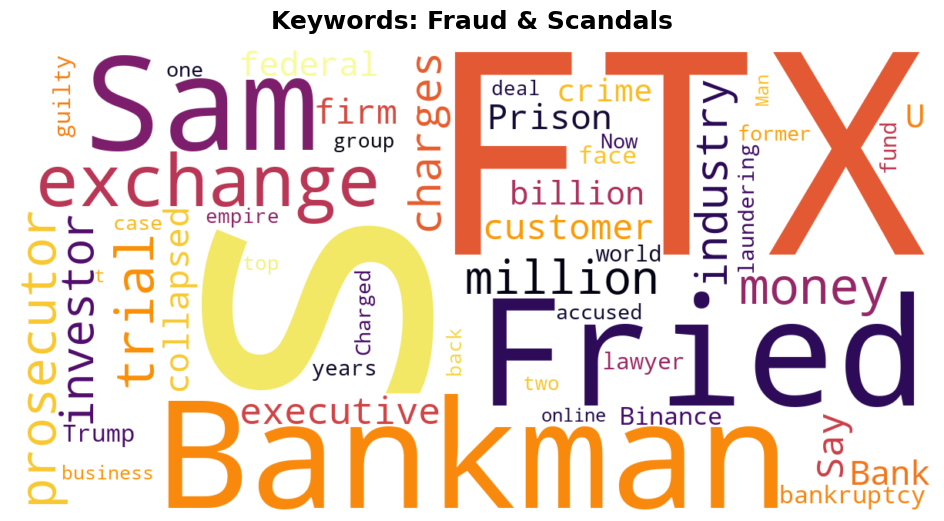




TOPIC: REGULATION & SEC
Articles found: 853
------------------------------------------------------------
5 Representative Examples:
   1. Will Blockchain Be a Boon to the Jewelry Industry?. Advocates say shared and secure data could help guarantee provenance, identify fakes and authentic...
   2. Iran and Russia move toward linking their banking systems, helping both withstand Western sanctions.. President Vladimir V. Putin of Russia had long b...
   3. Banks Tried to Kill Crypto and Failed. Now They’re Embracing It (Slowly).. Digital payments technology is forcing the financial system to evolve. Bank...
   4. Crypto Firm Pleads Guilty to Operating Illegally in U.S.. Federal prosecutors said OKX, based in Seychelles, violated anti-money laundering laws for y...
   5. Crypto Banking and Decentralized Finance, Explained. The revolution in digital money is now moving into banking, as cryptocurrency starts to reshape t...


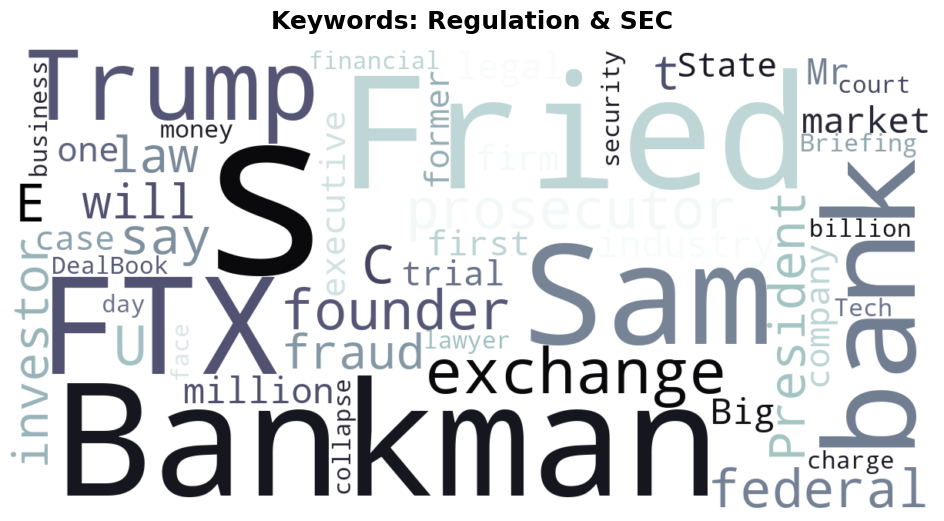




TOPIC: MARKET TRENDS
Articles found: 691
------------------------------------------------------------
5 Representative Examples:
   1. A Religious School That’s Also a Public School. Oklahoma’s decision to allow the Catholic church to operate a public school continues a winning streak...
   2. An A.I.-Generated Spoof Rattles the Markets. A stock sell-off driven by a since-debunked picture underscored fears about how artificial intelligence c...
   3. Inside the Private Writings of Caroline Ellison, Star Witness in the FTX Case. Ms. Ellison, a top executive in Sam Bankman-Fried’s business empire, re...
   4. It’s Memes vs. Regulators. Officials are looking for signs of manipulation behind the recent market frenzy....
   5. Stocks drop for a third day following Bitcoin’s crash and inflation concerns.. Stocks slumped for a third day as a bust in cryptocurrencies bled into ...


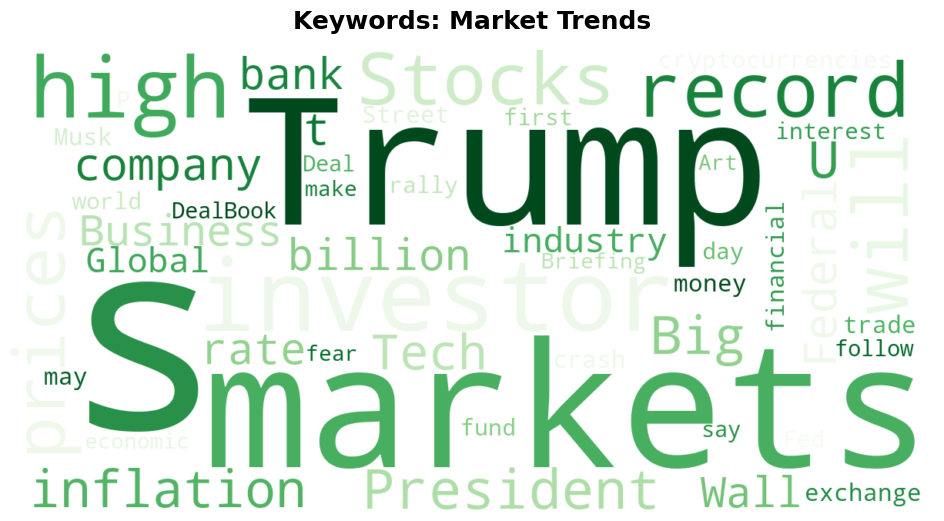

In [ ]:

# --- 1. CONFIGURATION ---
TOPICS_CONFIG = {
    "President Trump": {
        "keywords": ["trump", "donald", "president", "white house"],
        "stopwords_extra": ["trump", "donald", "president", "former", "white", "house", "mr", "administration", "campaign"],
        "colormap": "Reds" 
    },
    "Elon Musk": {
        "keywords": ["musk", "elon", "tesla", "spacex", "twitter", "x "], 
        "stopwords_extra": ["musk", "elon", "tesla", "twitter", "mr", "chief", "executive", "owner", "tech"],
        "colormap": "Blues"
    },
    "Fraud & Scandals": {
        "keywords": ["fraud", "scam", "ponzi", "scheme", "crime", "criminal", "prison", "jail", "bankrupt", "ftx", "sbf", "collapse", "laundering"],
        "stopwords_extra": ["fraud", "scam", "scheme", "criminal", "bankrupt", "collapse", "mr", "company", "founder"],
        "colormap": "inferno"
    },
    "Regulation & SEC": {
        "keywords": ["sec", "regulation", "law", "gensler", "government", "ban", "congress", "senate", "legal"],
        "stopwords_extra": ["sec", "regulation", "regulators", "rule", "government", "commission", "agency"],
        "colormap": "bone"
    },
    "Market Trends": {
        "keywords": ["price", "market", "crash", "rally", "plunge", "record", "high", "low", "volatility"],
        "stopwords_extra": ["price", "market", "value", "digital", "currency", "level", "trading", "stock"],
        "colormap": "Greens"
    }
}

# --- 2. DATA FILTERING ---
print("🔌 Filtering articles by topic...")
topic_texts = {k: [] for k in TOPICS_CONFIG.keys()}
cursor = collection.find({})

for doc in cursor:
    articles = doc.get('articles', [])
    for art in articles:
        t = art.get('title', '') or ""
        a = art.get('abstract', '') or ""
        full_text = f"{t}. {a}".strip()
        
        if len(full_text) > 15:
            full_text_lower = full_text.lower()
            for topic, config in TOPICS_CONFIG.items():
                if any(k in full_text_lower for k in config["keywords"]):
                    topic_texts[topic].append(full_text)

# --- 3. VISUALIZATION LOOP ---
base_stopwords = set(STOPWORDS)
base_stopwords.update(["Bitcoin", "Crypto", "Cryptocurrency", "Digital", "Currency", "New", "York", "Times", "Said", "Week", "Today", "Year", "People"])

for topic_name, texts_list in topic_texts.items():
    count = len(texts_list)
    config = TOPICS_CONFIG[topic_name]
    
    print("=" * 60)
    print(f"TOPIC: {topic_name.upper()}")
    print(f"Articles found: {count}")
    print("-" * 60)
    
    if count > 0:
        # A. Print Samples
        print(f"5 Representative Examples:")
        samples = [t.replace('\n', ' ') for t in random.sample(texts_list, min(5, count))]
        for idx, txt in enumerate(samples, 1):
            print(f"   {idx}. {txt[:150]}...")
            
        # B. Plot WordCloud
        combined_text = " ".join(texts_list)
        current_stopwords = base_stopwords.copy()
        current_stopwords.update([w.lower() for w in config["stopwords_extra"]])
        
        plt.figure(figsize=(12, 6))
        wc = WordCloud(width=1200, height=600, background_color='white', 
                       stopwords=current_stopwords, collocations=False,
                       colormap=config['colormap'], max_words=50).generate(combined_text)
        
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f"Keywords: {topic_name}", fontsize=18, fontweight='bold', pad=15)
        plt.axis('off')
        plt.show()
    else:
        print(f"No data available for {topic_name}.\n")
    
    print("\n" * 2)

Fetching data for N-Gram analysis...
Loaded 3658 documents.


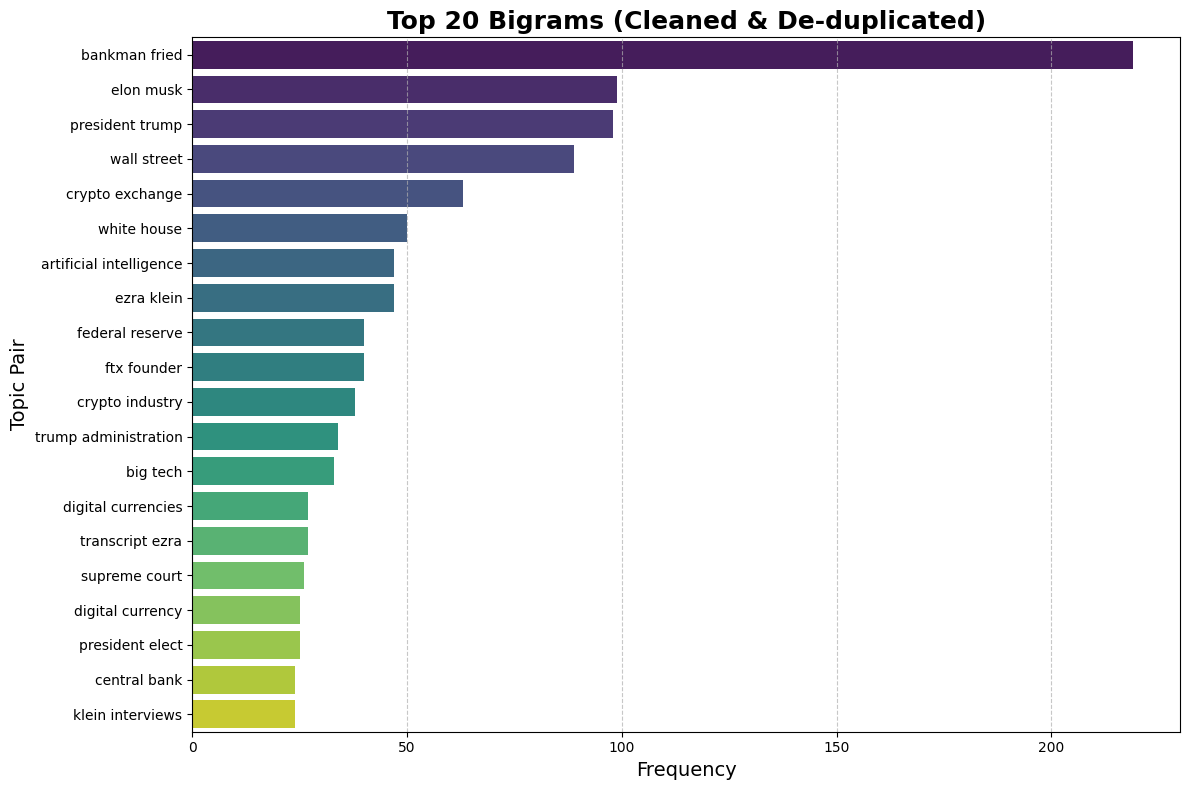


TOP 10 CLEAN BIGRAMS:
   1. Bankman Fried (219)
   2. Elon Musk (99)
   3. President Trump (98)
   4. Wall Street (89)
   5. Crypto Exchange (63)
   6. White House (50)
   7. Artificial Intelligence (47)
   8. Ezra Klein (47)
   9. Federal Reserve (40)
   10. Ftx Founder (40)


In [13]:
# --- 1. DATA PREPARATION ---
print("Fetching data for N-Gram analysis...")
corpus = []
cursor = collection.find({})

for doc in cursor:
    articles = doc.get('articles', [])
    for art in articles:
        t = art.get('title', '') or ""
        a = art.get('abstract', '') or ""
        full_text = f"{t} {a}".strip()
        if len(full_text) > 20:
            corpus.append(full_text)

print(f"Loaded {len(corpus)} documents.")

# --- 2. CONFIGURATION ---
# Expanded stopwords to remove noise
custom_stopwords_ngram = list(ENGLISH_STOP_WORDS) + [
    "new", "york", "times", "briefing", "daily", "today", "week", "year",
    "mr", "ms", "mrs", "said", "say", "says", "reporting", "source",
    "image", "photo", "credit", "getty", "associated", "press", 
    "need", "know", "start", "day", "latest", "end", "posted", "updated",
    "chief", "executive", "officer", "general"
]

# Specific Bigrams to hide (Redundant/Synonyms)
banned_bigrams = [
    "sam bankman", "donald trump", "cryptocurrency exchange", 
    "silicon valley", "social media", "start day", "latest end", 
    "need know", "dealbook newsletter", "united states"
]

# --- 3. ANALYSIS ---
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=custom_stopwords_ngram, min_df=5, max_features=2000)
X = vectorizer.fit_transform(corpus)

# Count and Filter
bigrams_list = list(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
cleaned_bigrams = [b for b in bigrams_list if b[0] not in banned_bigrams]
sorted_bigrams = sorted(cleaned_bigrams, key=lambda x: x[1], reverse=True)[:20]

# Create DataFrame
df_bigrams = pd.DataFrame(sorted_bigrams, columns=['Bigram', 'Frequency'])

# --- 4. VISUALIZATION ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Bigram', data=df_bigrams, palette='viridis')
plt.title('Top 20 Bigrams (Cleaned & De-duplicated)', fontsize=18, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Topic Pair', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTOP 10 CLEAN BIGRAMS:")
for i, (gram, freq) in enumerate(sorted_bigrams[:10], 1):
    print(f"   {i}. {gram.title()} ({freq})")